# 1. Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# Models
import xgboost as xgb
import catboost as cat
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# 2. Get Data

In [21]:
df = pd.read_csv('Titanic_data.csv')

In [7]:
df.head()

,Pclass,Age,SibSp,Parch,Fare,male,C,Q,S,Survived
0,3,22.0,1.0,0,7.2500,1,0,0,1,0
1,1,38.0,1.0,0,71.2833,0,1,0,0,1
2,3,26.0,0.0,0,7.9250,0,0,0,1,1
3,1,35.0,1.0,0,53.1000,0,0,0,1,1
4,3,35.0,0.0,0,8.0500,1,0,0,1,0


This data set is from Kaggle `titanic challenge` https://www.kaggle.com/c/titanic/data

* Pclass --> Passenger Class
* Age --> Age of Passenger
* SibSp --> Sibling = brother, sister, stepbrother, stepsister | Spouse = husband, wife (mistresses and fiancés were ignored)
* Parch --> Parents or Children
* Fare --> Ticket price
* Gender --> Simplified to binary, male == 1 and feamle=0(#Feminism)
* Boarding Port --> C
* Boarding Port --> Q
* Boarding Port --> S
* Survived --> Target variable, 1 for suriveved and 0 for deceased

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 10 columns):
Pclass      890 non-null int64
Age         890 non-null float64
SibSp       889 non-null float64
Parch       890 non-null int64
Fare        890 non-null float64
male        890 non-null int64
C           890 non-null int64
Q           890 non-null int64
S           890 non-null int64
Survived    890 non-null int64
dtypes: float64(3), int64(7)
memory usage: 69.6 KB


In [9]:
df.describe()

,Pclass,Age,SibSp,Parch,Fare,male,C,Q,S,Survived
count,890.000000,890.000000,889.000000,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000,890.000000
mean,2.307865,29.074539,0.515186,0.382022,32.231348,0.647191,0.188764,0.086517,0.722472,0.384270
std,0.836220,13.234840,1.074921,0.806409,49.714762,0.478113,0.391541,0.281284,0.448031,0.486696
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.903100,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,26.000000,0.000000,0.000000,14.454200,1.000000,0.000000,0.000000,1.000000,0.000000
75%,3.000000,37.000000,1.000000,0.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000


# 3. Exploratory Data Analysis

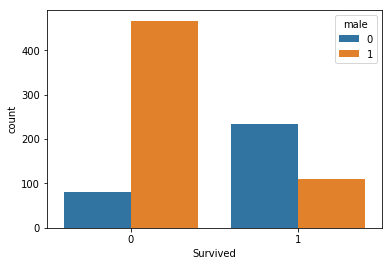

In [11]:
sns.countplot(x='Survived', data=df, hue='male')

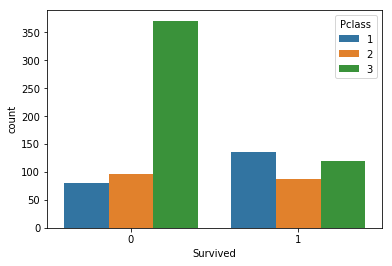

In [12]:
sns.countplot(x='Survived', data=df, hue='Pclass')

# 4. Clean Data

This data set has already been cleaned, seriously you should check it out on `Kaggle` it was a mess. The only thing I will do now is to standardise it, because our max fare price goes all the way to 512 and most features have a max value of 1, it will increase the accuracy of the models if the values been comapared/learnt from are on the same range.

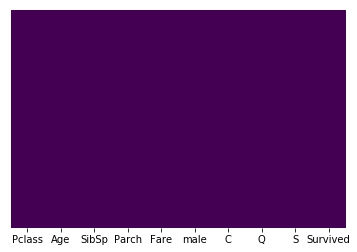

In [16]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [22]:
df = df.fillna(df.mean())

# Even though from my heatmap above it is clear that there are no NaNs,
# I kept getting an error when standardising, so I filled the NaNs, with mean values.
# Of course this is a bad approach, it will work for the age column, not all of them

In [23]:
X = df.drop('Survived', axis=1)
y = df['Survived']

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [24]:
X[:2]

array([[ 0.82816049, -0.53483964,  0.45153073, -0.47399939, -0.50277609,
         0.73833521, -0.48237639, -0.30775144,  0.61978775],
       [-1.56490066,  0.67477047,  0.45153073, -0.47399939,  0.78596192,
        -1.35439836,  2.07306996, -0.30775144, -1.61345557]])

# 5. Train Test Split

### (More accurately split, train and test)

In [25]:
# For a fair comparison I will use a random_state value(it is arbitrary)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [27]:
names = ['XGBoost', 'AdaBoost', 'GBC',  'Catboost']

In [26]:
classifiers = [
    xgb.XGBClassifier(),   
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    cat.CatBoostClassifier()
]

In [28]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)

    print ('... predicting')
    y_pred = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred)
    recall    = metrics.recall_score(y_train, y_pred)

    f1        = metrics.f1_score(y_train, y_pred)
    f1_test   = metrics.f1_score(y_test, y_pred_test)

    # save the results to dictionaries
    models[name] = clf
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)

    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])


results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

Fitting XGBoost model...
... predicting
... scoring
Fitting AdaBoost model...
... predicting
... scoring
Fitting GBC model...
... predicting
... scoring
Fitting Catboost model...
0:	learn: 0.6724634	total: 652ms	remaining: 10m 51s
1:	learn: 0.6567321	total: 935ms	remaining: 7m 46s
2:	learn: 0.6421393	total: 989ms	remaining: 5m 28s
3:	learn: 0.6335346	total: 995ms	remaining: 4m 7s
4:	learn: 0.6188870	total: 1.08s	remaining: 3m 36s
5:	learn: 0.6060110	total: 1.16s	remaining: 3m 12s
6:	learn: 0.5940411	total: 1.21s	remaining: 2m 51s
7:	learn: 0.5834418	total: 1.22s	remaining: 2m 31s
8:	learn: 0.5705062	total: 1.24s	remaining: 2m 16s
9:	learn: 0.5598781	total: 1.26s	remaining: 2m 4s
10:	learn: 0.5501638	total: 1.32s	remaining: 1m 58s
11:	learn: 0.5417524	total: 1.33s	remaining: 1m 49s
12:	learn: 0.5341535	total: 1.34s	remaining: 1m 41s
13:	learn: 0.5276924	total: 1.35s	remaining: 1m 35s
14:	learn: 0.5188990	total: 1.38s	remaining: 1m 30s
15:	learn: 0.5125799	total: 1.39s	remaining: 1m 25s


160:	learn: 0.3370221	total: 3.77s	remaining: 19.6s
161:	learn: 0.3363231	total: 3.78s	remaining: 19.6s
162:	learn: 0.3362947	total: 3.79s	remaining: 19.5s
163:	learn: 0.3354292	total: 3.81s	remaining: 19.4s
164:	learn: 0.3353648	total: 3.81s	remaining: 19.3s
165:	learn: 0.3349685	total: 3.83s	remaining: 19.2s
166:	learn: 0.3346345	total: 3.84s	remaining: 19.2s
167:	learn: 0.3339911	total: 3.86s	remaining: 19.1s
168:	learn: 0.3334542	total: 3.87s	remaining: 19s
169:	learn: 0.3330923	total: 3.88s	remaining: 19s
170:	learn: 0.3327484	total: 3.9s	remaining: 18.9s
171:	learn: 0.3323508	total: 3.91s	remaining: 18.8s
172:	learn: 0.3318806	total: 3.93s	remaining: 18.8s
173:	learn: 0.3315145	total: 3.94s	remaining: 18.7s
174:	learn: 0.3311727	total: 3.96s	remaining: 18.6s
175:	learn: 0.3309224	total: 3.97s	remaining: 18.6s
176:	learn: 0.3306679	total: 3.99s	remaining: 18.5s
177:	learn: 0.3300474	total: 4s	remaining: 18.5s
178:	learn: 0.3297930	total: 4.01s	remaining: 18.4s
179:	learn: 0.329479

322:	learn: 0.2791629	total: 6.34s	remaining: 13.3s
323:	learn: 0.2789887	total: 6.37s	remaining: 13.3s
324:	learn: 0.2785732	total: 6.39s	remaining: 13.3s
325:	learn: 0.2780301	total: 6.41s	remaining: 13.2s
326:	learn: 0.2777555	total: 6.42s	remaining: 13.2s
327:	learn: 0.2771941	total: 6.43s	remaining: 13.2s
328:	learn: 0.2769214	total: 6.45s	remaining: 13.2s
329:	learn: 0.2767756	total: 6.46s	remaining: 13.1s
330:	learn: 0.2765954	total: 6.48s	remaining: 13.1s
331:	learn: 0.2763468	total: 6.49s	remaining: 13.1s
332:	learn: 0.2760066	total: 6.5s	remaining: 13s
333:	learn: 0.2755091	total: 6.52s	remaining: 13s
334:	learn: 0.2753786	total: 6.54s	remaining: 13s
335:	learn: 0.2750884	total: 6.56s	remaining: 13s
336:	learn: 0.2749190	total: 6.58s	remaining: 12.9s
337:	learn: 0.2747152	total: 6.59s	remaining: 12.9s
338:	learn: 0.2744021	total: 6.61s	remaining: 12.9s
339:	learn: 0.2742505	total: 6.62s	remaining: 12.9s
340:	learn: 0.2740688	total: 6.64s	remaining: 12.8s
341:	learn: 0.2736982

482:	learn: 0.2397553	total: 9.62s	remaining: 10.3s
483:	learn: 0.2395427	total: 9.64s	remaining: 10.3s
484:	learn: 0.2389586	total: 9.65s	remaining: 10.3s
485:	learn: 0.2388742	total: 9.67s	remaining: 10.2s
486:	learn: 0.2386811	total: 9.68s	remaining: 10.2s
487:	learn: 0.2386461	total: 9.7s	remaining: 10.2s
488:	learn: 0.2385521	total: 9.71s	remaining: 10.1s
489:	learn: 0.2381335	total: 9.73s	remaining: 10.1s
490:	learn: 0.2379570	total: 9.74s	remaining: 10.1s
491:	learn: 0.2378401	total: 9.76s	remaining: 10.1s
492:	learn: 0.2376565	total: 9.77s	remaining: 10s
493:	learn: 0.2375545	total: 9.79s	remaining: 10s
494:	learn: 0.2374169	total: 9.8s	remaining: 10s
495:	learn: 0.2371959	total: 9.81s	remaining: 9.97s
496:	learn: 0.2370653	total: 9.83s	remaining: 9.95s
497:	learn: 0.2365830	total: 9.84s	remaining: 9.92s
498:	learn: 0.2363289	total: 9.86s	remaining: 9.89s
499:	learn: 0.2362077	total: 9.87s	remaining: 9.87s
500:	learn: 0.2360026	total: 9.89s	remaining: 9.85s
501:	learn: 0.235909

642:	learn: 0.2128552	total: 12.2s	remaining: 6.78s
643:	learn: 0.2127494	total: 12.2s	remaining: 6.76s
644:	learn: 0.2127021	total: 12.2s	remaining: 6.74s
645:	learn: 0.2125940	total: 12.2s	remaining: 6.71s
646:	learn: 0.2125783	total: 12.2s	remaining: 6.69s
647:	learn: 0.2124988	total: 12.3s	remaining: 6.67s
648:	learn: 0.2124421	total: 12.3s	remaining: 6.65s
649:	learn: 0.2123190	total: 12.3s	remaining: 6.63s
650:	learn: 0.2118644	total: 12.3s	remaining: 6.6s
651:	learn: 0.2117579	total: 12.3s	remaining: 6.58s
652:	learn: 0.2116432	total: 12.3s	remaining: 6.56s
653:	learn: 0.2115385	total: 12.3s	remaining: 6.54s
654:	learn: 0.2112072	total: 12.4s	remaining: 6.52s
655:	learn: 0.2111115	total: 12.4s	remaining: 6.5s
656:	learn: 0.2109529	total: 12.4s	remaining: 6.47s
657:	learn: 0.2108632	total: 12.4s	remaining: 6.45s
658:	learn: 0.2106658	total: 12.4s	remaining: 6.43s
659:	learn: 0.2105020	total: 12.4s	remaining: 6.41s
660:	learn: 0.2104304	total: 12.4s	remaining: 6.39s
661:	learn: 0.

806:	learn: 0.1928400	total: 14.7s	remaining: 3.53s
807:	learn: 0.1927541	total: 14.7s	remaining: 3.51s
808:	learn: 0.1925338	total: 14.8s	remaining: 3.49s
809:	learn: 0.1924421	total: 14.8s	remaining: 3.47s
810:	learn: 0.1923758	total: 14.8s	remaining: 3.45s
811:	learn: 0.1923300	total: 14.8s	remaining: 3.43s
812:	learn: 0.1921808	total: 14.8s	remaining: 3.41s
813:	learn: 0.1919989	total: 14.8s	remaining: 3.39s
814:	learn: 0.1918644	total: 14.8s	remaining: 3.37s
815:	learn: 0.1918459	total: 14.9s	remaining: 3.35s
816:	learn: 0.1916959	total: 14.9s	remaining: 3.33s
817:	learn: 0.1914791	total: 14.9s	remaining: 3.31s
818:	learn: 0.1912991	total: 14.9s	remaining: 3.3s
819:	learn: 0.1911785	total: 14.9s	remaining: 3.28s
820:	learn: 0.1910445	total: 14.9s	remaining: 3.26s
821:	learn: 0.1908761	total: 14.9s	remaining: 3.24s
822:	learn: 0.1907634	total: 15s	remaining: 3.22s
823:	learn: 0.1907190	total: 15s	remaining: 3.2s
824:	learn: 0.1904779	total: 15s	remaining: 3.18s
825:	learn: 0.190364

972:	learn: 0.1752050	total: 17.3s	remaining: 480ms
973:	learn: 0.1749925	total: 17.3s	remaining: 462ms
974:	learn: 0.1748535	total: 17.3s	remaining: 444ms
975:	learn: 0.1747921	total: 17.3s	remaining: 426ms
976:	learn: 0.1747224	total: 17.3s	remaining: 408ms
977:	learn: 0.1743335	total: 17.3s	remaining: 390ms
978:	learn: 0.1741468	total: 17.3s	remaining: 373ms
979:	learn: 0.1740338	total: 17.4s	remaining: 355ms
980:	learn: 0.1739219	total: 17.4s	remaining: 337ms
981:	learn: 0.1737992	total: 17.4s	remaining: 319ms
982:	learn: 0.1737698	total: 17.4s	remaining: 301ms
983:	learn: 0.1737316	total: 17.4s	remaining: 284ms
984:	learn: 0.1736541	total: 17.4s	remaining: 266ms
985:	learn: 0.1736159	total: 17.5s	remaining: 248ms
986:	learn: 0.1734948	total: 17.5s	remaining: 231ms
987:	learn: 0.1731861	total: 17.5s	remaining: 213ms
988:	learn: 0.1730989	total: 17.5s	remaining: 195ms
989:	learn: 0.1730381	total: 17.5s	remaining: 177ms
990:	learn: 0.1730293	total: 17.5s	remaining: 159ms
991:	learn: 

138:	learn: 0.3426313	total: 2.06s	remaining: 12.8s
139:	learn: 0.3420834	total: 2.08s	remaining: 12.7s
140:	learn: 0.3417440	total: 2.09s	remaining: 12.7s
141:	learn: 0.3411163	total: 2.11s	remaining: 12.8s
142:	learn: 0.3407542	total: 2.13s	remaining: 12.7s
143:	learn: 0.3403970	total: 2.14s	remaining: 12.7s
144:	learn: 0.3397904	total: 2.16s	remaining: 12.7s
145:	learn: 0.3396642	total: 2.19s	remaining: 12.8s
146:	learn: 0.3391521	total: 2.2s	remaining: 12.8s
147:	learn: 0.3385451	total: 2.22s	remaining: 12.8s
148:	learn: 0.3380234	total: 2.23s	remaining: 12.7s
149:	learn: 0.3372744	total: 2.25s	remaining: 12.7s
150:	learn: 0.3368009	total: 2.26s	remaining: 12.7s
151:	learn: 0.3362802	total: 2.28s	remaining: 12.7s
152:	learn: 0.3358544	total: 2.3s	remaining: 12.7s
153:	learn: 0.3353709	total: 2.32s	remaining: 12.8s
154:	learn: 0.3349110	total: 2.34s	remaining: 12.8s
155:	learn: 0.3347758	total: 2.36s	remaining: 12.8s
156:	learn: 0.3341587	total: 2.38s	remaining: 12.8s
157:	learn: 0.

297:	learn: 0.2814218	total: 4.67s	remaining: 11s
298:	learn: 0.2811784	total: 4.71s	remaining: 11.1s
299:	learn: 0.2810805	total: 4.73s	remaining: 11s
300:	learn: 0.2809495	total: 4.75s	remaining: 11s
301:	learn: 0.2808398	total: 4.76s	remaining: 11s
302:	learn: 0.2806853	total: 4.78s	remaining: 11s
303:	learn: 0.2805193	total: 4.79s	remaining: 11s
304:	learn: 0.2802163	total: 4.81s	remaining: 11s
305:	learn: 0.2794947	total: 4.82s	remaining: 10.9s
306:	learn: 0.2794567	total: 4.84s	remaining: 10.9s
307:	learn: 0.2792489	total: 4.86s	remaining: 10.9s
308:	learn: 0.2789340	total: 4.87s	remaining: 10.9s
309:	learn: 0.2782378	total: 4.89s	remaining: 10.9s
310:	learn: 0.2774518	total: 4.9s	remaining: 10.9s
311:	learn: 0.2769429	total: 4.92s	remaining: 10.8s
312:	learn: 0.2765789	total: 4.93s	remaining: 10.8s
313:	learn: 0.2763903	total: 4.94s	remaining: 10.8s
314:	learn: 0.2762957	total: 4.96s	remaining: 10.8s
315:	learn: 0.2760167	total: 4.97s	remaining: 10.8s
316:	learn: 0.2757612	total

456:	learn: 0.2427556	total: 7.15s	remaining: 8.5s
457:	learn: 0.2424418	total: 7.17s	remaining: 8.48s
458:	learn: 0.2422154	total: 7.18s	remaining: 8.46s
459:	learn: 0.2420478	total: 7.2s	remaining: 8.45s
460:	learn: 0.2416753	total: 7.21s	remaining: 8.43s
461:	learn: 0.2414535	total: 7.22s	remaining: 8.41s
462:	learn: 0.2411709	total: 7.24s	remaining: 8.39s
463:	learn: 0.2411157	total: 7.26s	remaining: 8.38s
464:	learn: 0.2410141	total: 7.28s	remaining: 8.37s
465:	learn: 0.2408622	total: 7.29s	remaining: 8.36s
466:	learn: 0.2405081	total: 7.31s	remaining: 8.34s
467:	learn: 0.2401878	total: 7.32s	remaining: 8.32s
468:	learn: 0.2401438	total: 7.34s	remaining: 8.31s
469:	learn: 0.2398435	total: 7.36s	remaining: 8.29s
470:	learn: 0.2396845	total: 7.37s	remaining: 8.28s
471:	learn: 0.2396275	total: 7.38s	remaining: 8.26s
472:	learn: 0.2394982	total: 7.4s	remaining: 8.24s
473:	learn: 0.2391912	total: 7.41s	remaining: 8.23s
474:	learn: 0.2390007	total: 7.43s	remaining: 8.21s
475:	learn: 0.2

618:	learn: 0.2147497	total: 9.65s	remaining: 5.94s
619:	learn: 0.2147203	total: 9.67s	remaining: 5.92s
620:	learn: 0.2145758	total: 9.68s	remaining: 5.91s
621:	learn: 0.2145416	total: 9.7s	remaining: 5.89s
622:	learn: 0.2144982	total: 9.71s	remaining: 5.88s
623:	learn: 0.2144077	total: 9.72s	remaining: 5.86s
624:	learn: 0.2142504	total: 9.74s	remaining: 5.84s
625:	learn: 0.2141043	total: 9.75s	remaining: 5.83s
626:	learn: 0.2140169	total: 9.77s	remaining: 5.81s
627:	learn: 0.2138121	total: 9.78s	remaining: 5.79s
628:	learn: 0.2136553	total: 9.8s	remaining: 5.78s
629:	learn: 0.2134792	total: 9.81s	remaining: 5.76s
630:	learn: 0.2133879	total: 9.83s	remaining: 5.75s
631:	learn: 0.2133664	total: 9.84s	remaining: 5.73s
632:	learn: 0.2131824	total: 9.86s	remaining: 5.71s
633:	learn: 0.2129561	total: 9.87s	remaining: 5.7s
634:	learn: 0.2129275	total: 9.89s	remaining: 5.68s
635:	learn: 0.2127635	total: 9.9s	remaining: 5.67s
636:	learn: 0.2125012	total: 9.92s	remaining: 5.65s
637:	learn: 0.21

788:	learn: 0.1940166	total: 12.2s	remaining: 3.25s
789:	learn: 0.1939065	total: 12.2s	remaining: 3.24s
790:	learn: 0.1937565	total: 12.2s	remaining: 3.22s
791:	learn: 0.1936137	total: 12.2s	remaining: 3.2s
792:	learn: 0.1934931	total: 12.2s	remaining: 3.19s
793:	learn: 0.1931715	total: 12.2s	remaining: 3.17s
794:	learn: 0.1930660	total: 12.2s	remaining: 3.16s
795:	learn: 0.1928278	total: 12.3s	remaining: 3.14s
796:	learn: 0.1927062	total: 12.3s	remaining: 3.13s
797:	learn: 0.1926044	total: 12.3s	remaining: 3.11s
798:	learn: 0.1925532	total: 12.3s	remaining: 3.1s
799:	learn: 0.1923488	total: 12.3s	remaining: 3.08s
800:	learn: 0.1923362	total: 12.3s	remaining: 3.06s
801:	learn: 0.1921982	total: 12.4s	remaining: 3.05s
802:	learn: 0.1920660	total: 12.4s	remaining: 3.03s
803:	learn: 0.1919412	total: 12.4s	remaining: 3.02s
804:	learn: 0.1918892	total: 12.4s	remaining: 3s
805:	learn: 0.1917708	total: 12.4s	remaining: 2.99s
806:	learn: 0.1915992	total: 12.4s	remaining: 2.97s
807:	learn: 0.191

957:	learn: 0.1766259	total: 15.5s	remaining: 679ms
958:	learn: 0.1764383	total: 15.5s	remaining: 663ms
959:	learn: 0.1762937	total: 15.5s	remaining: 646ms
960:	learn: 0.1762884	total: 15.5s	remaining: 630ms
961:	learn: 0.1762685	total: 15.5s	remaining: 614ms
962:	learn: 0.1761699	total: 15.6s	remaining: 598ms
963:	learn: 0.1760348	total: 15.6s	remaining: 581ms
964:	learn: 0.1759875	total: 15.6s	remaining: 565ms
965:	learn: 0.1759606	total: 15.6s	remaining: 549ms
966:	learn: 0.1758530	total: 15.6s	remaining: 533ms
967:	learn: 0.1756355	total: 15.6s	remaining: 517ms
968:	learn: 0.1754709	total: 15.6s	remaining: 500ms
969:	learn: 0.1752973	total: 15.7s	remaining: 484ms
970:	learn: 0.1752818	total: 15.7s	remaining: 468ms
971:	learn: 0.1751939	total: 15.7s	remaining: 452ms
972:	learn: 0.1751136	total: 15.7s	remaining: 436ms
973:	learn: 0.1750784	total: 15.7s	remaining: 420ms
974:	learn: 0.1750648	total: 15.7s	remaining: 403ms
975:	learn: 0.1750559	total: 15.7s	remaining: 387ms
976:	learn: 

118:	learn: 0.3566491	total: 1.89s	remaining: 14s
119:	learn: 0.3558771	total: 1.91s	remaining: 14s
120:	learn: 0.3554644	total: 1.93s	remaining: 14s
121:	learn: 0.3554542	total: 1.94s	remaining: 13.9s
122:	learn: 0.3547215	total: 1.95s	remaining: 13.9s
123:	learn: 0.3543523	total: 1.96s	remaining: 13.9s
124:	learn: 0.3542779	total: 1.97s	remaining: 13.8s
125:	learn: 0.3534294	total: 1.99s	remaining: 13.8s
126:	learn: 0.3530289	total: 2s	remaining: 13.8s
127:	learn: 0.3527508	total: 2.02s	remaining: 13.8s
128:	learn: 0.3524486	total: 2.03s	remaining: 13.7s
129:	learn: 0.3523787	total: 2.04s	remaining: 13.7s
130:	learn: 0.3522935	total: 2.06s	remaining: 13.6s
131:	learn: 0.3517040	total: 2.07s	remaining: 13.6s
132:	learn: 0.3516971	total: 2.08s	remaining: 13.6s
133:	learn: 0.3511495	total: 2.1s	remaining: 13.6s
134:	learn: 0.3503974	total: 2.12s	remaining: 13.6s
135:	learn: 0.3502890	total: 2.13s	remaining: 13.5s
136:	learn: 0.3499610	total: 2.15s	remaining: 13.5s
137:	learn: 0.3493871	

284:	learn: 0.2914363	total: 4.53s	remaining: 11.4s
285:	learn: 0.2911384	total: 4.55s	remaining: 11.4s
286:	learn: 0.2908664	total: 4.57s	remaining: 11.4s
287:	learn: 0.2899985	total: 4.59s	remaining: 11.3s
288:	learn: 0.2897681	total: 4.6s	remaining: 11.3s
289:	learn: 0.2892129	total: 4.62s	remaining: 11.3s
290:	learn: 0.2886381	total: 4.63s	remaining: 11.3s
291:	learn: 0.2884703	total: 4.65s	remaining: 11.3s
292:	learn: 0.2881786	total: 4.66s	remaining: 11.2s
293:	learn: 0.2877970	total: 4.68s	remaining: 11.2s
294:	learn: 0.2871458	total: 4.69s	remaining: 11.2s
295:	learn: 0.2870612	total: 4.71s	remaining: 11.2s
296:	learn: 0.2869094	total: 4.73s	remaining: 11.2s
297:	learn: 0.2864045	total: 4.75s	remaining: 11.2s
298:	learn: 0.2856054	total: 4.77s	remaining: 11.2s
299:	learn: 0.2853358	total: 4.79s	remaining: 11.2s
300:	learn: 0.2852484	total: 4.81s	remaining: 11.2s
301:	learn: 0.2851007	total: 4.83s	remaining: 11.2s
302:	learn: 0.2848840	total: 4.85s	remaining: 11.1s
303:	learn: 0

451:	learn: 0.2423399	total: 7.71s	remaining: 9.35s
452:	learn: 0.2419291	total: 7.73s	remaining: 9.33s
453:	learn: 0.2418193	total: 7.75s	remaining: 9.32s
454:	learn: 0.2417385	total: 7.77s	remaining: 9.31s
455:	learn: 0.2416136	total: 7.79s	remaining: 9.29s
456:	learn: 0.2410114	total: 7.8s	remaining: 9.27s
457:	learn: 0.2408626	total: 7.82s	remaining: 9.26s
458:	learn: 0.2404933	total: 7.84s	remaining: 9.24s
459:	learn: 0.2402453	total: 7.86s	remaining: 9.22s
460:	learn: 0.2401552	total: 7.94s	remaining: 9.28s
461:	learn: 0.2398001	total: 7.96s	remaining: 9.27s
462:	learn: 0.2393748	total: 7.99s	remaining: 9.26s
463:	learn: 0.2391303	total: 8.01s	remaining: 9.25s
464:	learn: 0.2389401	total: 8.02s	remaining: 9.23s
465:	learn: 0.2387731	total: 8.04s	remaining: 9.22s
466:	learn: 0.2384592	total: 8.06s	remaining: 9.2s
467:	learn: 0.2384437	total: 8.08s	remaining: 9.18s
468:	learn: 0.2382408	total: 8.09s	remaining: 9.16s
469:	learn: 0.2381667	total: 8.11s	remaining: 9.15s
470:	learn: 0.

614:	learn: 0.2118154	total: 10.7s	remaining: 6.68s
615:	learn: 0.2116803	total: 10.7s	remaining: 6.66s
616:	learn: 0.2115286	total: 10.7s	remaining: 6.64s
617:	learn: 0.2114832	total: 10.7s	remaining: 6.62s
618:	learn: 0.2112942	total: 10.7s	remaining: 6.61s
619:	learn: 0.2112096	total: 10.7s	remaining: 6.59s
620:	learn: 0.2110422	total: 10.8s	remaining: 6.57s
621:	learn: 0.2109455	total: 10.8s	remaining: 6.55s
622:	learn: 0.2108774	total: 10.8s	remaining: 6.53s
623:	learn: 0.2107561	total: 10.8s	remaining: 6.52s
624:	learn: 0.2105773	total: 10.8s	remaining: 6.5s
625:	learn: 0.2104323	total: 10.9s	remaining: 6.48s
626:	learn: 0.2103182	total: 10.9s	remaining: 6.47s
627:	learn: 0.2102640	total: 10.9s	remaining: 6.45s
628:	learn: 0.2099349	total: 10.9s	remaining: 6.43s
629:	learn: 0.2097778	total: 10.9s	remaining: 6.42s
630:	learn: 0.2095654	total: 10.9s	remaining: 6.4s
631:	learn: 0.2095064	total: 11s	remaining: 6.38s
632:	learn: 0.2094418	total: 11s	remaining: 6.36s
633:	learn: 0.2092

777:	learn: 0.1906021	total: 14s	remaining: 3.99s
778:	learn: 0.1905349	total: 14s	remaining: 3.97s
779:	learn: 0.1903527	total: 14s	remaining: 3.95s
780:	learn: 0.1903044	total: 14s	remaining: 3.94s
781:	learn: 0.1900603	total: 14.1s	remaining: 3.92s
782:	learn: 0.1900034	total: 14.1s	remaining: 3.9s
783:	learn: 0.1899523	total: 14.1s	remaining: 3.88s
784:	learn: 0.1898226	total: 14.1s	remaining: 3.86s
785:	learn: 0.1897287	total: 14.1s	remaining: 3.84s
786:	learn: 0.1895851	total: 14.1s	remaining: 3.83s
787:	learn: 0.1895418	total: 14.2s	remaining: 3.81s
788:	learn: 0.1894563	total: 14.2s	remaining: 3.8s
789:	learn: 0.1893534	total: 14.2s	remaining: 3.78s
790:	learn: 0.1891654	total: 14.2s	remaining: 3.76s
791:	learn: 0.1889265	total: 14.3s	remaining: 3.75s
792:	learn: 0.1888855	total: 14.3s	remaining: 3.73s
793:	learn: 0.1886741	total: 14.3s	remaining: 3.71s
794:	learn: 0.1885568	total: 14.3s	remaining: 3.69s
795:	learn: 0.1883245	total: 14.3s	remaining: 3.67s
796:	learn: 0.1882327	

940:	learn: 0.1719139	total: 16.9s	remaining: 1.06s
941:	learn: 0.1717348	total: 16.9s	remaining: 1.04s
942:	learn: 0.1716393	total: 16.9s	remaining: 1.02s
943:	learn: 0.1716099	total: 16.9s	remaining: 1s
944:	learn: 0.1714672	total: 17s	remaining: 987ms
945:	learn: 0.1714314	total: 17s	remaining: 969ms
946:	learn: 0.1713530	total: 17s	remaining: 951ms
947:	learn: 0.1713184	total: 17s	remaining: 933ms
948:	learn: 0.1712934	total: 17s	remaining: 915ms
949:	learn: 0.1712480	total: 17s	remaining: 897ms
950:	learn: 0.1711148	total: 17.1s	remaining: 879ms
951:	learn: 0.1710330	total: 17.1s	remaining: 861ms
952:	learn: 0.1709361	total: 17.1s	remaining: 844ms
953:	learn: 0.1708227	total: 17.1s	remaining: 827ms
954:	learn: 0.1707807	total: 17.2s	remaining: 809ms
955:	learn: 0.1707213	total: 17.2s	remaining: 791ms
956:	learn: 0.1705757	total: 17.2s	remaining: 773ms
957:	learn: 0.1704637	total: 17.2s	remaining: 755ms
958:	learn: 0.1703378	total: 17.2s	remaining: 737ms
959:	learn: 0.1702169	total

102:	learn: 0.3636295	total: 2.15s	remaining: 18.7s
103:	learn: 0.3626929	total: 2.19s	remaining: 18.8s
104:	learn: 0.3612618	total: 2.2s	remaining: 18.8s
105:	learn: 0.3609874	total: 2.21s	remaining: 18.7s
106:	learn: 0.3604903	total: 2.23s	remaining: 18.6s
107:	learn: 0.3597119	total: 2.25s	remaining: 18.6s
108:	learn: 0.3592039	total: 2.26s	remaining: 18.5s
109:	learn: 0.3589889	total: 2.27s	remaining: 18.4s
110:	learn: 0.3585418	total: 2.29s	remaining: 18.4s
111:	learn: 0.3585243	total: 2.3s	remaining: 18.2s
112:	learn: 0.3574199	total: 2.31s	remaining: 18.1s
113:	learn: 0.3573821	total: 2.32s	remaining: 18s
114:	learn: 0.3569220	total: 2.33s	remaining: 18s
115:	learn: 0.3566511	total: 2.35s	remaining: 17.9s
116:	learn: 0.3562642	total: 2.38s	remaining: 17.9s
117:	learn: 0.3558925	total: 2.4s	remaining: 17.9s
118:	learn: 0.3552244	total: 2.42s	remaining: 17.9s
119:	learn: 0.3549759	total: 2.43s	remaining: 17.8s
120:	learn: 0.3546865	total: 2.44s	remaining: 17.8s
121:	learn: 0.35439

271:	learn: 0.2932721	total: 4.87s	remaining: 13s
272:	learn: 0.2927279	total: 4.89s	remaining: 13s
273:	learn: 0.2923717	total: 4.9s	remaining: 13s
274:	learn: 0.2914891	total: 4.92s	remaining: 13s
275:	learn: 0.2909469	total: 4.93s	remaining: 12.9s
276:	learn: 0.2901016	total: 4.95s	remaining: 12.9s
277:	learn: 0.2900287	total: 4.96s	remaining: 12.9s
278:	learn: 0.2892101	total: 4.98s	remaining: 12.9s
279:	learn: 0.2888980	total: 4.99s	remaining: 12.8s
280:	learn: 0.2884361	total: 5s	remaining: 12.8s
281:	learn: 0.2881857	total: 5.04s	remaining: 12.8s
282:	learn: 0.2880015	total: 5.07s	remaining: 12.8s
283:	learn: 0.2876964	total: 5.08s	remaining: 12.8s
284:	learn: 0.2873777	total: 5.1s	remaining: 12.8s
285:	learn: 0.2871873	total: 5.12s	remaining: 12.8s
286:	learn: 0.2868623	total: 5.13s	remaining: 12.8s
287:	learn: 0.2864727	total: 5.15s	remaining: 12.7s
288:	learn: 0.2856636	total: 5.17s	remaining: 12.7s
289:	learn: 0.2854549	total: 5.2s	remaining: 12.7s
290:	learn: 0.2852816	tota

438:	learn: 0.2403181	total: 7.93s	remaining: 10.1s
439:	learn: 0.2400554	total: 7.96s	remaining: 10.1s
440:	learn: 0.2399704	total: 7.98s	remaining: 10.1s
441:	learn: 0.2398177	total: 8s	remaining: 10.1s
442:	learn: 0.2396519	total: 8.01s	remaining: 10.1s
443:	learn: 0.2395295	total: 8.03s	remaining: 10.1s
444:	learn: 0.2392425	total: 8.04s	remaining: 10s
445:	learn: 0.2390267	total: 8.06s	remaining: 10s
446:	learn: 0.2389274	total: 8.08s	remaining: 9.99s
447:	learn: 0.2383858	total: 8.09s	remaining: 9.97s
448:	learn: 0.2381737	total: 8.11s	remaining: 9.95s
449:	learn: 0.2380659	total: 8.14s	remaining: 9.95s
450:	learn: 0.2379503	total: 8.16s	remaining: 9.93s
451:	learn: 0.2376178	total: 8.17s	remaining: 9.91s
452:	learn: 0.2375510	total: 8.19s	remaining: 9.89s
453:	learn: 0.2371460	total: 8.21s	remaining: 9.87s
454:	learn: 0.2368813	total: 8.23s	remaining: 9.85s
455:	learn: 0.2367633	total: 8.24s	remaining: 9.83s
456:	learn: 0.2365312	total: 8.26s	remaining: 9.81s
457:	learn: 0.23630

599:	learn: 0.2089053	total: 10.9s	remaining: 7.27s
600:	learn: 0.2087403	total: 10.9s	remaining: 7.25s
601:	learn: 0.2086097	total: 11s	remaining: 7.24s
602:	learn: 0.2084877	total: 11s	remaining: 7.23s
603:	learn: 0.2083977	total: 11s	remaining: 7.22s
604:	learn: 0.2083146	total: 11s	remaining: 7.2s
605:	learn: 0.2082616	total: 11s	remaining: 7.18s
606:	learn: 0.2081516	total: 11.1s	remaining: 7.16s
607:	learn: 0.2079900	total: 11.1s	remaining: 7.17s
608:	learn: 0.2078826	total: 11.1s	remaining: 7.16s
609:	learn: 0.2074721	total: 11.2s	remaining: 7.14s
610:	learn: 0.2073740	total: 11.2s	remaining: 7.12s
611:	learn: 0.2072502	total: 11.2s	remaining: 7.1s
612:	learn: 0.2072311	total: 11.2s	remaining: 7.08s
613:	learn: 0.2071536	total: 11.2s	remaining: 7.06s
614:	learn: 0.2067605	total: 11.2s	remaining: 7.04s
615:	learn: 0.2067324	total: 11.3s	remaining: 7.02s
616:	learn: 0.2065765	total: 11.3s	remaining: 7s
617:	learn: 0.2065142	total: 11.3s	remaining: 6.97s
618:	learn: 0.2063846	total

771:	learn: 0.1842607	total: 15.2s	remaining: 4.49s
772:	learn: 0.1841191	total: 15.2s	remaining: 4.47s
773:	learn: 0.1840646	total: 15.2s	remaining: 4.45s
774:	learn: 0.1839545	total: 15.2s	remaining: 4.43s
775:	learn: 0.1839278	total: 15.3s	remaining: 4.41s
776:	learn: 0.1838879	total: 15.3s	remaining: 4.38s
777:	learn: 0.1838037	total: 15.3s	remaining: 4.36s
778:	learn: 0.1836566	total: 15.3s	remaining: 4.34s
779:	learn: 0.1834002	total: 15.3s	remaining: 4.32s
780:	learn: 0.1832956	total: 15.3s	remaining: 4.3s
781:	learn: 0.1832407	total: 15.3s	remaining: 4.28s
782:	learn: 0.1831330	total: 15.4s	remaining: 4.26s
783:	learn: 0.1831089	total: 15.4s	remaining: 4.24s
784:	learn: 0.1829624	total: 15.4s	remaining: 4.22s
785:	learn: 0.1828823	total: 15.4s	remaining: 4.2s
786:	learn: 0.1826871	total: 15.4s	remaining: 4.17s
787:	learn: 0.1826535	total: 15.4s	remaining: 4.15s
788:	learn: 0.1825840	total: 15.5s	remaining: 4.13s
789:	learn: 0.1824746	total: 15.5s	remaining: 4.12s
790:	learn: 0.

938:	learn: 0.1657510	total: 18.2s	remaining: 1.18s
939:	learn: 0.1656853	total: 18.2s	remaining: 1.16s
940:	learn: 0.1655431	total: 18.2s	remaining: 1.14s
941:	learn: 0.1654027	total: 18.2s	remaining: 1.12s
942:	learn: 0.1653535	total: 18.3s	remaining: 1.1s
943:	learn: 0.1652510	total: 18.3s	remaining: 1.08s
944:	learn: 0.1652242	total: 18.3s	remaining: 1.06s
945:	learn: 0.1650857	total: 18.3s	remaining: 1.04s
946:	learn: 0.1649766	total: 18.3s	remaining: 1.02s
947:	learn: 0.1647807	total: 18.3s	remaining: 1s
948:	learn: 0.1647459	total: 18.3s	remaining: 986ms
949:	learn: 0.1646247	total: 18.4s	remaining: 966ms
950:	learn: 0.1645589	total: 18.4s	remaining: 946ms
951:	learn: 0.1644697	total: 18.4s	remaining: 927ms
952:	learn: 0.1644229	total: 18.4s	remaining: 908ms
953:	learn: 0.1643659	total: 18.4s	remaining: 888ms
954:	learn: 0.1643481	total: 18.4s	remaining: 869ms
955:	learn: 0.1641412	total: 18.5s	remaining: 849ms
956:	learn: 0.1640942	total: 18.5s	remaining: 830ms
957:	learn: 0.16

112:	learn: 0.3644021	total: 1.8s	remaining: 14.2s
113:	learn: 0.3640266	total: 1.82s	remaining: 14.1s
114:	learn: 0.3639273	total: 1.83s	remaining: 14.1s
115:	learn: 0.3638302	total: 1.84s	remaining: 14s
116:	learn: 0.3626613	total: 1.86s	remaining: 14s
117:	learn: 0.3625445	total: 1.87s	remaining: 14s
118:	learn: 0.3614680	total: 1.91s	remaining: 14.1s
119:	learn: 0.3610403	total: 1.93s	remaining: 14.1s
120:	learn: 0.3606821	total: 1.94s	remaining: 14.1s
121:	learn: 0.3601355	total: 1.98s	remaining: 14.3s
122:	learn: 0.3599918	total: 2.02s	remaining: 14.4s
123:	learn: 0.3599744	total: 2.04s	remaining: 14.5s
124:	learn: 0.3595100	total: 2.11s	remaining: 14.8s
125:	learn: 0.3590452	total: 2.17s	remaining: 15s
126:	learn: 0.3583782	total: 2.19s	remaining: 15s
127:	learn: 0.3575606	total: 2.23s	remaining: 15.2s
128:	learn: 0.3569959	total: 2.28s	remaining: 15.4s
129:	learn: 0.3566685	total: 2.31s	remaining: 15.4s
130:	learn: 0.3562130	total: 2.35s	remaining: 15.6s
131:	learn: 0.3556223	t

282:	learn: 0.2877192	total: 5.88s	remaining: 14.9s
283:	learn: 0.2873162	total: 5.89s	remaining: 14.9s
284:	learn: 0.2870378	total: 5.91s	remaining: 14.8s
285:	learn: 0.2867708	total: 5.92s	remaining: 14.8s
286:	learn: 0.2863394	total: 5.94s	remaining: 14.7s
287:	learn: 0.2860234	total: 5.95s	remaining: 14.7s
288:	learn: 0.2856164	total: 5.96s	remaining: 14.7s
289:	learn: 0.2849458	total: 5.99s	remaining: 14.7s
290:	learn: 0.2845953	total: 6.01s	remaining: 14.6s
291:	learn: 0.2844775	total: 6.03s	remaining: 14.6s
292:	learn: 0.2841550	total: 6.04s	remaining: 14.6s
293:	learn: 0.2838864	total: 6.05s	remaining: 14.5s
294:	learn: 0.2837080	total: 6.07s	remaining: 14.5s
295:	learn: 0.2831857	total: 6.08s	remaining: 14.5s
296:	learn: 0.2829582	total: 6.11s	remaining: 14.5s
297:	learn: 0.2827012	total: 6.12s	remaining: 14.4s
298:	learn: 0.2819620	total: 6.14s	remaining: 14.4s
299:	learn: 0.2815724	total: 6.15s	remaining: 14.4s
300:	learn: 0.2811943	total: 6.17s	remaining: 14.3s
301:	learn: 

444:	learn: 0.2375471	total: 8.49s	remaining: 10.6s
445:	learn: 0.2371733	total: 8.52s	remaining: 10.6s
446:	learn: 0.2369022	total: 8.54s	remaining: 10.6s
447:	learn: 0.2367020	total: 8.55s	remaining: 10.5s
448:	learn: 0.2361985	total: 8.56s	remaining: 10.5s
449:	learn: 0.2358392	total: 8.58s	remaining: 10.5s
450:	learn: 0.2353896	total: 8.59s	remaining: 10.5s
451:	learn: 0.2349002	total: 8.61s	remaining: 10.4s
452:	learn: 0.2346421	total: 8.62s	remaining: 10.4s
453:	learn: 0.2344586	total: 8.63s	remaining: 10.4s
454:	learn: 0.2341955	total: 8.65s	remaining: 10.4s
455:	learn: 0.2335215	total: 8.66s	remaining: 10.3s
456:	learn: 0.2333335	total: 8.68s	remaining: 10.3s
457:	learn: 0.2332162	total: 8.7s	remaining: 10.3s
458:	learn: 0.2330818	total: 8.72s	remaining: 10.3s
459:	learn: 0.2329875	total: 8.73s	remaining: 10.3s
460:	learn: 0.2328492	total: 8.75s	remaining: 10.2s
461:	learn: 0.2326662	total: 8.76s	remaining: 10.2s
462:	learn: 0.2324484	total: 8.78s	remaining: 10.2s
463:	learn: 0

607:	learn: 0.2028748	total: 11.5s	remaining: 7.41s
608:	learn: 0.2027441	total: 11.5s	remaining: 7.41s
609:	learn: 0.2026976	total: 11.6s	remaining: 7.39s
610:	learn: 0.2025998	total: 11.6s	remaining: 7.38s
611:	learn: 0.2024557	total: 11.6s	remaining: 7.37s
612:	learn: 0.2023617	total: 11.6s	remaining: 7.35s
613:	learn: 0.2021737	total: 11.7s	remaining: 7.34s
614:	learn: 0.2020605	total: 11.7s	remaining: 7.32s
615:	learn: 0.2018730	total: 11.7s	remaining: 7.31s
616:	learn: 0.2017215	total: 11.8s	remaining: 7.29s
617:	learn: 0.2016319	total: 11.8s	remaining: 7.28s
618:	learn: 0.2014393	total: 11.8s	remaining: 7.26s
619:	learn: 0.2010977	total: 11.8s	remaining: 7.24s
620:	learn: 0.2010133	total: 11.8s	remaining: 7.22s
621:	learn: 0.2009636	total: 11.9s	remaining: 7.2s
622:	learn: 0.2008728	total: 11.9s	remaining: 7.18s
623:	learn: 0.2004494	total: 11.9s	remaining: 7.16s
624:	learn: 0.2003118	total: 11.9s	remaining: 7.14s
625:	learn: 0.2000808	total: 11.9s	remaining: 7.12s
626:	learn: 0

768:	learn: 0.1808014	total: 14.5s	remaining: 4.36s
769:	learn: 0.1806243	total: 14.5s	remaining: 4.34s
770:	learn: 0.1805445	total: 14.6s	remaining: 4.32s
771:	learn: 0.1803867	total: 14.6s	remaining: 4.3s
772:	learn: 0.1802578	total: 14.6s	remaining: 4.28s
773:	learn: 0.1801588	total: 14.6s	remaining: 4.26s
774:	learn: 0.1799100	total: 14.6s	remaining: 4.25s
775:	learn: 0.1798784	total: 14.6s	remaining: 4.23s
776:	learn: 0.1798547	total: 14.7s	remaining: 4.21s
777:	learn: 0.1798119	total: 14.7s	remaining: 4.19s
778:	learn: 0.1797286	total: 14.7s	remaining: 4.17s
779:	learn: 0.1794290	total: 14.7s	remaining: 4.15s
780:	learn: 0.1793720	total: 14.7s	remaining: 4.13s
781:	learn: 0.1792828	total: 14.7s	remaining: 4.11s
782:	learn: 0.1791549	total: 14.8s	remaining: 4.09s
783:	learn: 0.1790462	total: 14.8s	remaining: 4.07s
784:	learn: 0.1787746	total: 14.9s	remaining: 4.07s
785:	learn: 0.1786355	total: 14.9s	remaining: 4.05s
786:	learn: 0.1784845	total: 14.9s	remaining: 4.04s
787:	learn: 0

931:	learn: 0.1655489	total: 18.6s	remaining: 1.36s
932:	learn: 0.1655063	total: 18.6s	remaining: 1.34s
933:	learn: 0.1654113	total: 18.6s	remaining: 1.32s
934:	learn: 0.1653568	total: 18.7s	remaining: 1.3s
935:	learn: 0.1651681	total: 18.7s	remaining: 1.28s
936:	learn: 0.1650762	total: 18.7s	remaining: 1.26s
937:	learn: 0.1650444	total: 18.7s	remaining: 1.24s
938:	learn: 0.1650009	total: 18.7s	remaining: 1.22s
939:	learn: 0.1649724	total: 18.8s	remaining: 1.2s
940:	learn: 0.1647781	total: 18.8s	remaining: 1.18s
941:	learn: 0.1646724	total: 18.8s	remaining: 1.16s
942:	learn: 0.1645866	total: 18.8s	remaining: 1.14s
943:	learn: 0.1645522	total: 18.9s	remaining: 1.12s
944:	learn: 0.1645143	total: 19s	remaining: 1.1s
945:	learn: 0.1644561	total: 19s	remaining: 1.08s
946:	learn: 0.1643777	total: 19s	remaining: 1.06s
947:	learn: 0.1641311	total: 19s	remaining: 1.04s
948:	learn: 0.1639845	total: 19s	remaining: 1.02s
949:	learn: 0.1639300	total: 19.1s	remaining: 1s
950:	learn: 0.1638233	total:

93:	learn: 0.3683631	total: 1.38s	remaining: 13.3s
94:	learn: 0.3681966	total: 1.39s	remaining: 13.2s
95:	learn: 0.3681100	total: 1.39s	remaining: 13.1s
96:	learn: 0.3677808	total: 1.41s	remaining: 13.1s
97:	learn: 0.3666860	total: 1.42s	remaining: 13.1s
98:	learn: 0.3660311	total: 1.44s	remaining: 13.1s
99:	learn: 0.3652733	total: 1.46s	remaining: 13.1s
100:	learn: 0.3645260	total: 1.47s	remaining: 13.1s
101:	learn: 0.3637766	total: 1.49s	remaining: 13.1s
102:	learn: 0.3635547	total: 1.51s	remaining: 13.1s
103:	learn: 0.3634085	total: 1.52s	remaining: 13.1s
104:	learn: 0.3625220	total: 1.53s	remaining: 13.1s
105:	learn: 0.3618307	total: 1.55s	remaining: 13.1s
106:	learn: 0.3614339	total: 1.57s	remaining: 13.1s
107:	learn: 0.3607661	total: 1.58s	remaining: 13.1s
108:	learn: 0.3601353	total: 1.6s	remaining: 13.1s
109:	learn: 0.3597284	total: 1.62s	remaining: 13.1s
110:	learn: 0.3596204	total: 1.63s	remaining: 13s
111:	learn: 0.3592149	total: 1.64s	remaining: 13s
112:	learn: 0.3589091	to

260:	learn: 0.3033431	total: 4.08s	remaining: 11.6s
261:	learn: 0.3030364	total: 4.1s	remaining: 11.5s
262:	learn: 0.3027758	total: 4.12s	remaining: 11.5s
263:	learn: 0.3024923	total: 4.13s	remaining: 11.5s
264:	learn: 0.3023044	total: 4.15s	remaining: 11.5s
265:	learn: 0.3018468	total: 4.16s	remaining: 11.5s
266:	learn: 0.3010962	total: 4.18s	remaining: 11.5s
267:	learn: 0.3001879	total: 4.19s	remaining: 11.5s
268:	learn: 0.2998331	total: 4.21s	remaining: 11.4s
269:	learn: 0.2995728	total: 4.22s	remaining: 11.4s
270:	learn: 0.2992874	total: 4.24s	remaining: 11.4s
271:	learn: 0.2988991	total: 4.26s	remaining: 11.4s
272:	learn: 0.2985932	total: 4.27s	remaining: 11.4s
273:	learn: 0.2980079	total: 4.29s	remaining: 11.4s
274:	learn: 0.2976131	total: 4.31s	remaining: 11.4s
275:	learn: 0.2972350	total: 4.32s	remaining: 11.3s
276:	learn: 0.2966224	total: 4.34s	remaining: 11.3s
277:	learn: 0.2961744	total: 4.35s	remaining: 11.3s
278:	learn: 0.2958294	total: 4.38s	remaining: 11.3s
279:	learn: 0

432:	learn: 0.2496286	total: 6.8s	remaining: 8.91s
433:	learn: 0.2494543	total: 6.82s	remaining: 8.89s
434:	learn: 0.2492622	total: 6.84s	remaining: 8.88s
435:	learn: 0.2490882	total: 6.85s	remaining: 8.86s
436:	learn: 0.2488955	total: 6.87s	remaining: 8.85s
437:	learn: 0.2487026	total: 6.88s	remaining: 8.84s
438:	learn: 0.2485144	total: 6.9s	remaining: 8.82s
439:	learn: 0.2484552	total: 6.92s	remaining: 8.8s
440:	learn: 0.2483506	total: 6.93s	remaining: 8.79s
441:	learn: 0.2477662	total: 6.95s	remaining: 8.77s
442:	learn: 0.2472903	total: 6.96s	remaining: 8.75s
443:	learn: 0.2471414	total: 6.97s	remaining: 8.73s
444:	learn: 0.2468743	total: 6.99s	remaining: 8.72s
445:	learn: 0.2465891	total: 7.01s	remaining: 8.7s
446:	learn: 0.2464605	total: 7.02s	remaining: 8.69s
447:	learn: 0.2462651	total: 7.04s	remaining: 8.67s
448:	learn: 0.2458867	total: 7.05s	remaining: 8.65s
449:	learn: 0.2453875	total: 7.07s	remaining: 8.63s
450:	learn: 0.2453397	total: 7.08s	remaining: 8.62s
451:	learn: 0.24

604:	learn: 0.2168151	total: 9.72s	remaining: 6.35s
605:	learn: 0.2167709	total: 9.74s	remaining: 6.33s
606:	learn: 0.2164926	total: 9.76s	remaining: 6.32s
607:	learn: 0.2162334	total: 9.77s	remaining: 6.3s
608:	learn: 0.2160817	total: 9.79s	remaining: 6.28s
609:	learn: 0.2159967	total: 9.8s	remaining: 6.27s
610:	learn: 0.2158405	total: 9.82s	remaining: 6.25s
611:	learn: 0.2156202	total: 9.83s	remaining: 6.23s
612:	learn: 0.2153812	total: 9.85s	remaining: 6.22s
613:	learn: 0.2153075	total: 9.86s	remaining: 6.2s
614:	learn: 0.2152269	total: 9.88s	remaining: 6.18s
615:	learn: 0.2151229	total: 9.89s	remaining: 6.17s
616:	learn: 0.2150818	total: 9.91s	remaining: 6.15s
617:	learn: 0.2150019	total: 9.93s	remaining: 6.14s
618:	learn: 0.2148705	total: 9.94s	remaining: 6.12s
619:	learn: 0.2147245	total: 9.96s	remaining: 6.1s
620:	learn: 0.2145202	total: 9.97s	remaining: 6.08s
621:	learn: 0.2144945	total: 9.99s	remaining: 6.07s
622:	learn: 0.2141057	total: 10s	remaining: 6.05s
623:	learn: 0.2139

772:	learn: 0.1937059	total: 12.8s	remaining: 3.76s
773:	learn: 0.1935397	total: 12.8s	remaining: 3.75s
774:	learn: 0.1934881	total: 12.9s	remaining: 3.73s
775:	learn: 0.1933367	total: 12.9s	remaining: 3.72s
776:	learn: 0.1932152	total: 12.9s	remaining: 3.71s
777:	learn: 0.1931747	total: 12.9s	remaining: 3.69s
778:	learn: 0.1930535	total: 13s	remaining: 3.68s
779:	learn: 0.1928299	total: 13s	remaining: 3.66s
780:	learn: 0.1927385	total: 13s	remaining: 3.65s
781:	learn: 0.1921532	total: 13s	remaining: 3.63s
782:	learn: 0.1920723	total: 13s	remaining: 3.61s
783:	learn: 0.1919306	total: 13.1s	remaining: 3.6s
784:	learn: 0.1917478	total: 13.1s	remaining: 3.58s
785:	learn: 0.1916664	total: 13.1s	remaining: 3.56s
786:	learn: 0.1916321	total: 13.1s	remaining: 3.55s
787:	learn: 0.1914893	total: 13.1s	remaining: 3.53s
788:	learn: 0.1914289	total: 13.1s	remaining: 3.51s
789:	learn: 0.1913601	total: 13.2s	remaining: 3.5s
790:	learn: 0.1911678	total: 13.2s	remaining: 3.48s
791:	learn: 0.1911389	to

939:	learn: 0.1771370	total: 16.4s	remaining: 1.04s
940:	learn: 0.1768915	total: 16.4s	remaining: 1.03s
941:	learn: 0.1766935	total: 16.4s	remaining: 1.01s
942:	learn: 0.1766681	total: 16.4s	remaining: 992ms
943:	learn: 0.1766013	total: 16.4s	remaining: 975ms
944:	learn: 0.1765347	total: 16.4s	remaining: 957ms
945:	learn: 0.1764550	total: 16.5s	remaining: 940ms
946:	learn: 0.1763986	total: 16.5s	remaining: 922ms
947:	learn: 0.1763521	total: 16.5s	remaining: 905ms
948:	learn: 0.1763353	total: 16.5s	remaining: 887ms
949:	learn: 0.1762338	total: 16.5s	remaining: 870ms
950:	learn: 0.1761968	total: 16.5s	remaining: 852ms
951:	learn: 0.1761157	total: 16.6s	remaining: 835ms
952:	learn: 0.1760590	total: 16.6s	remaining: 818ms
953:	learn: 0.1760521	total: 16.6s	remaining: 801ms
954:	learn: 0.1759321	total: 16.6s	remaining: 783ms
955:	learn: 0.1759112	total: 16.6s	remaining: 766ms
956:	learn: 0.1758399	total: 16.7s	remaining: 748ms
957:	learn: 0.1758298	total: 16.7s	remaining: 731ms
958:	learn: 

111:	learn: 0.3643643	total: 1.85s	remaining: 14.7s
112:	learn: 0.3636797	total: 1.86s	remaining: 14.6s
113:	learn: 0.3628082	total: 1.91s	remaining: 14.9s
114:	learn: 0.3622846	total: 1.93s	remaining: 14.9s
115:	learn: 0.3616670	total: 1.96s	remaining: 14.9s
116:	learn: 0.3616567	total: 1.97s	remaining: 14.9s
117:	learn: 0.3609841	total: 1.99s	remaining: 14.9s
118:	learn: 0.3607724	total: 2s	remaining: 14.8s
119:	learn: 0.3604809	total: 2.01s	remaining: 14.8s
120:	learn: 0.3596777	total: 2.03s	remaining: 14.8s
121:	learn: 0.3588574	total: 2.06s	remaining: 14.8s
122:	learn: 0.3584702	total: 2.08s	remaining: 14.9s
123:	learn: 0.3582538	total: 2.09s	remaining: 14.8s
124:	learn: 0.3577440	total: 2.11s	remaining: 14.8s
125:	learn: 0.3573590	total: 2.12s	remaining: 14.7s
126:	learn: 0.3570042	total: 2.14s	remaining: 14.7s
127:	learn: 0.3564742	total: 2.15s	remaining: 14.7s
128:	learn: 0.3555611	total: 2.17s	remaining: 14.6s
129:	learn: 0.3553246	total: 2.18s	remaining: 14.6s
130:	learn: 0.3

272:	learn: 0.2979975	total: 4.74s	remaining: 12.6s
273:	learn: 0.2976750	total: 4.78s	remaining: 12.7s
274:	learn: 0.2975247	total: 4.83s	remaining: 12.7s
275:	learn: 0.2970661	total: 4.84s	remaining: 12.7s
276:	learn: 0.2967272	total: 4.86s	remaining: 12.7s
277:	learn: 0.2961724	total: 4.88s	remaining: 12.7s
278:	learn: 0.2954555	total: 4.89s	remaining: 12.6s
279:	learn: 0.2950345	total: 4.91s	remaining: 12.6s
280:	learn: 0.2948796	total: 4.92s	remaining: 12.6s
281:	learn: 0.2946186	total: 4.94s	remaining: 12.6s
282:	learn: 0.2942554	total: 4.96s	remaining: 12.6s
283:	learn: 0.2937654	total: 4.97s	remaining: 12.5s
284:	learn: 0.2932003	total: 4.99s	remaining: 12.5s
285:	learn: 0.2929546	total: 5.01s	remaining: 12.5s
286:	learn: 0.2924942	total: 5.02s	remaining: 12.5s
287:	learn: 0.2923349	total: 5.04s	remaining: 12.5s
288:	learn: 0.2920276	total: 5.05s	remaining: 12.4s
289:	learn: 0.2916161	total: 5.07s	remaining: 12.4s
290:	learn: 0.2911908	total: 5.09s	remaining: 12.4s
291:	learn: 

431:	learn: 0.2460015	total: 7.71s	remaining: 10.1s
432:	learn: 0.2456835	total: 7.73s	remaining: 10.1s
433:	learn: 0.2454796	total: 7.75s	remaining: 10.1s
434:	learn: 0.2452595	total: 7.77s	remaining: 10.1s
435:	learn: 0.2449555	total: 7.79s	remaining: 10.1s
436:	learn: 0.2442097	total: 7.81s	remaining: 10.1s
437:	learn: 0.2439171	total: 7.83s	remaining: 10.1s
438:	learn: 0.2438852	total: 7.86s	remaining: 10s
439:	learn: 0.2437433	total: 7.87s	remaining: 10s
440:	learn: 0.2431607	total: 7.91s	remaining: 10s
441:	learn: 0.2431104	total: 7.92s	remaining: 10s
442:	learn: 0.2430012	total: 7.94s	remaining: 9.98s
443:	learn: 0.2427606	total: 7.95s	remaining: 9.96s
444:	learn: 0.2422872	total: 7.97s	remaining: 9.95s
445:	learn: 0.2419442	total: 8s	remaining: 9.93s
446:	learn: 0.2417542	total: 8.01s	remaining: 9.91s
447:	learn: 0.2416916	total: 8.03s	remaining: 9.9s
448:	learn: 0.2412522	total: 8.06s	remaining: 9.89s
449:	learn: 0.2410624	total: 8.07s	remaining: 9.87s
450:	learn: 0.2409701	to

596:	learn: 0.2132573	total: 11.4s	remaining: 7.67s
597:	learn: 0.2132067	total: 11.4s	remaining: 7.65s
598:	learn: 0.2131246	total: 11.4s	remaining: 7.63s
599:	learn: 0.2127460	total: 11.4s	remaining: 7.61s
600:	learn: 0.2125033	total: 11.4s	remaining: 7.59s
601:	learn: 0.2124354	total: 11.4s	remaining: 7.57s
602:	learn: 0.2122905	total: 11.5s	remaining: 7.55s
603:	learn: 0.2120856	total: 11.5s	remaining: 7.53s
604:	learn: 0.2119112	total: 11.5s	remaining: 7.51s
605:	learn: 0.2117663	total: 11.5s	remaining: 7.49s
606:	learn: 0.2115939	total: 11.5s	remaining: 7.47s
607:	learn: 0.2112498	total: 11.6s	remaining: 7.45s
608:	learn: 0.2112058	total: 11.6s	remaining: 7.43s
609:	learn: 0.2111572	total: 11.6s	remaining: 7.41s
610:	learn: 0.2110817	total: 11.6s	remaining: 7.39s
611:	learn: 0.2109808	total: 11.6s	remaining: 7.37s
612:	learn: 0.2108642	total: 11.6s	remaining: 7.35s
613:	learn: 0.2107528	total: 11.7s	remaining: 7.33s
614:	learn: 0.2104473	total: 11.7s	remaining: 7.31s
615:	learn: 

762:	learn: 0.1897065	total: 14.1s	remaining: 4.37s
763:	learn: 0.1896538	total: 14.1s	remaining: 4.35s
764:	learn: 0.1895775	total: 14.1s	remaining: 4.33s
765:	learn: 0.1894920	total: 14.1s	remaining: 4.31s
766:	learn: 0.1893294	total: 14.1s	remaining: 4.29s
767:	learn: 0.1892970	total: 14.2s	remaining: 4.28s
768:	learn: 0.1891137	total: 14.2s	remaining: 4.26s
769:	learn: 0.1889960	total: 14.2s	remaining: 4.24s
770:	learn: 0.1889521	total: 14.2s	remaining: 4.22s
771:	learn: 0.1887619	total: 14.2s	remaining: 4.2s
772:	learn: 0.1884957	total: 14.2s	remaining: 4.18s
773:	learn: 0.1884088	total: 14.3s	remaining: 4.16s
774:	learn: 0.1883018	total: 14.3s	remaining: 4.14s
775:	learn: 0.1881912	total: 14.3s	remaining: 4.13s
776:	learn: 0.1880818	total: 14.3s	remaining: 4.11s
777:	learn: 0.1880311	total: 14.3s	remaining: 4.09s
778:	learn: 0.1879336	total: 14.3s	remaining: 4.07s
779:	learn: 0.1876030	total: 14.4s	remaining: 4.05s
780:	learn: 0.1875001	total: 14.4s	remaining: 4.03s
781:	learn: 0

932:	learn: 0.1710211	total: 17.2s	remaining: 1.24s
933:	learn: 0.1709296	total: 17.2s	remaining: 1.22s
934:	learn: 0.1708260	total: 17.2s	remaining: 1.2s
935:	learn: 0.1706915	total: 17.3s	remaining: 1.18s
936:	learn: 0.1706498	total: 17.3s	remaining: 1.16s
937:	learn: 0.1704978	total: 17.3s	remaining: 1.14s
938:	learn: 0.1704340	total: 17.3s	remaining: 1.12s
939:	learn: 0.1703982	total: 17.3s	remaining: 1.1s
940:	learn: 0.1703234	total: 17.3s	remaining: 1.09s
941:	learn: 0.1702693	total: 17.4s	remaining: 1.07s
942:	learn: 0.1702049	total: 17.4s	remaining: 1.05s
943:	learn: 0.1701524	total: 17.4s	remaining: 1.03s
944:	learn: 0.1699210	total: 17.4s	remaining: 1.01s
945:	learn: 0.1697762	total: 17.4s	remaining: 994ms
946:	learn: 0.1696852	total: 18s	remaining: 1s
947:	learn: 0.1696603	total: 18s	remaining: 986ms
948:	learn: 0.1695347	total: 18s	remaining: 967ms
949:	learn: 0.1694810	total: 18s	remaining: 948ms
950:	learn: 0.1693963	total: 18s	remaining: 929ms
951:	learn: 0.1693654	total

95:	learn: 0.3719479	total: 1.62s	remaining: 15.2s
96:	learn: 0.3715352	total: 1.64s	remaining: 15.3s
97:	learn: 0.3711186	total: 1.65s	remaining: 15.2s
98:	learn: 0.3703991	total: 1.67s	remaining: 15.2s
99:	learn: 0.3699747	total: 1.69s	remaining: 15.2s
100:	learn: 0.3693828	total: 1.71s	remaining: 15.2s
101:	learn: 0.3688790	total: 1.72s	remaining: 15.1s
102:	learn: 0.3679321	total: 1.74s	remaining: 15.1s
103:	learn: 0.3674724	total: 1.76s	remaining: 15.2s
104:	learn: 0.3665329	total: 1.78s	remaining: 15.2s
105:	learn: 0.3657818	total: 1.8s	remaining: 15.2s
106:	learn: 0.3652999	total: 1.81s	remaining: 15.1s
107:	learn: 0.3647447	total: 1.83s	remaining: 15.1s
108:	learn: 0.3635770	total: 1.85s	remaining: 15.1s
109:	learn: 0.3635337	total: 1.85s	remaining: 15s
110:	learn: 0.3632075	total: 1.87s	remaining: 15s
111:	learn: 0.3629814	total: 1.89s	remaining: 15s
112:	learn: 0.3624384	total: 1.9s	remaining: 14.9s
113:	learn: 0.3621661	total: 1.92s	remaining: 14.9s
114:	learn: 0.3617082	tot

261:	learn: 0.2902450	total: 4.75s	remaining: 13.4s
262:	learn: 0.2898075	total: 4.76s	remaining: 13.4s
263:	learn: 0.2892976	total: 4.78s	remaining: 13.3s
264:	learn: 0.2891009	total: 4.8s	remaining: 13.3s
265:	learn: 0.2887058	total: 4.81s	remaining: 13.3s
266:	learn: 0.2884604	total: 4.83s	remaining: 13.3s
267:	learn: 0.2882020	total: 4.85s	remaining: 13.3s
268:	learn: 0.2879228	total: 4.87s	remaining: 13.2s
269:	learn: 0.2875158	total: 4.89s	remaining: 13.2s
270:	learn: 0.2871587	total: 4.9s	remaining: 13.2s
271:	learn: 0.2863744	total: 4.92s	remaining: 13.2s
272:	learn: 0.2861012	total: 4.94s	remaining: 13.2s
273:	learn: 0.2856830	total: 4.96s	remaining: 13.1s
274:	learn: 0.2853755	total: 4.97s	remaining: 13.1s
275:	learn: 0.2850794	total: 4.99s	remaining: 13.1s
276:	learn: 0.2843810	total: 5.01s	remaining: 13.1s
277:	learn: 0.2839485	total: 5.03s	remaining: 13.1s
278:	learn: 0.2835118	total: 5.17s	remaining: 13.4s
279:	learn: 0.2830195	total: 5.19s	remaining: 13.3s
280:	learn: 0.

428:	learn: 0.2362155	total: 7.85s	remaining: 10.5s
429:	learn: 0.2361323	total: 7.88s	remaining: 10.4s
430:	learn: 0.2358513	total: 7.89s	remaining: 10.4s
431:	learn: 0.2357173	total: 7.91s	remaining: 10.4s
432:	learn: 0.2353989	total: 7.93s	remaining: 10.4s
433:	learn: 0.2351909	total: 7.94s	remaining: 10.4s
434:	learn: 0.2350373	total: 7.96s	remaining: 10.3s
435:	learn: 0.2348304	total: 7.98s	remaining: 10.3s
436:	learn: 0.2345632	total: 8s	remaining: 10.3s
437:	learn: 0.2343382	total: 8.01s	remaining: 10.3s
438:	learn: 0.2339416	total: 8.03s	remaining: 10.3s
439:	learn: 0.2336145	total: 8.05s	remaining: 10.2s
440:	learn: 0.2333763	total: 8.07s	remaining: 10.2s
441:	learn: 0.2333038	total: 8.09s	remaining: 10.2s
442:	learn: 0.2331528	total: 8.11s	remaining: 10.2s
443:	learn: 0.2327196	total: 8.13s	remaining: 10.2s
444:	learn: 0.2325273	total: 8.15s	remaining: 10.2s
445:	learn: 0.2324197	total: 8.17s	remaining: 10.1s
446:	learn: 0.2321152	total: 8.19s	remaining: 10.1s
447:	learn: 0.2

591:	learn: 0.2044035	total: 10.8s	remaining: 7.42s
592:	learn: 0.2043478	total: 10.8s	remaining: 7.4s
593:	learn: 0.2042037	total: 10.8s	remaining: 7.38s
594:	learn: 0.2041270	total: 10.8s	remaining: 7.36s
595:	learn: 0.2040667	total: 10.8s	remaining: 7.34s
596:	learn: 0.2037781	total: 10.9s	remaining: 7.33s
597:	learn: 0.2035212	total: 10.9s	remaining: 7.31s
598:	learn: 0.2033593	total: 10.9s	remaining: 7.29s
599:	learn: 0.2032834	total: 10.9s	remaining: 7.27s
600:	learn: 0.2031999	total: 10.9s	remaining: 7.25s
601:	learn: 0.2030154	total: 10.9s	remaining: 7.23s
602:	learn: 0.2028845	total: 11s	remaining: 7.21s
603:	learn: 0.2028349	total: 11s	remaining: 7.19s
604:	learn: 0.2025934	total: 11s	remaining: 7.18s
605:	learn: 0.2024256	total: 11s	remaining: 7.16s
606:	learn: 0.2023785	total: 11s	remaining: 7.14s
607:	learn: 0.2021789	total: 11s	remaining: 7.12s
608:	learn: 0.2021120	total: 11.1s	remaining: 7.1s
609:	learn: 0.2018620	total: 11.1s	remaining: 7.08s
610:	learn: 0.2016874	tota

761:	learn: 0.1830341	total: 13.8s	remaining: 4.31s
762:	learn: 0.1829373	total: 13.8s	remaining: 4.29s
763:	learn: 0.1828847	total: 13.8s	remaining: 4.27s
764:	learn: 0.1828571	total: 13.8s	remaining: 4.25s
765:	learn: 0.1827272	total: 13.9s	remaining: 4.23s
766:	learn: 0.1825029	total: 13.9s	remaining: 4.21s
767:	learn: 0.1823767	total: 13.9s	remaining: 4.2s
768:	learn: 0.1822636	total: 13.9s	remaining: 4.18s
769:	learn: 0.1821794	total: 13.9s	remaining: 4.16s
770:	learn: 0.1820823	total: 13.9s	remaining: 4.14s
771:	learn: 0.1819958	total: 14s	remaining: 4.12s
772:	learn: 0.1819142	total: 14s	remaining: 4.1s
773:	learn: 0.1818271	total: 14s	remaining: 4.09s
774:	learn: 0.1816409	total: 14s	remaining: 4.07s
775:	learn: 0.1814777	total: 14s	remaining: 4.05s
776:	learn: 0.1814437	total: 14.1s	remaining: 4.03s
777:	learn: 0.1813570	total: 14.1s	remaining: 4.01s
778:	learn: 0.1812561	total: 14.1s	remaining: 4s
779:	learn: 0.1811723	total: 14.1s	remaining: 3.98s
780:	learn: 0.1811331	total

923:	learn: 0.1675168	total: 16.6s	remaining: 1.37s
924:	learn: 0.1674615	total: 16.7s	remaining: 1.35s
925:	learn: 0.1673138	total: 16.7s	remaining: 1.33s
926:	learn: 0.1672273	total: 16.7s	remaining: 1.31s
927:	learn: 0.1672054	total: 16.7s	remaining: 1.3s
928:	learn: 0.1670789	total: 16.7s	remaining: 1.28s
929:	learn: 0.1670615	total: 16.8s	remaining: 1.26s
930:	learn: 0.1670281	total: 16.8s	remaining: 1.24s
931:	learn: 0.1668119	total: 16.8s	remaining: 1.22s
932:	learn: 0.1667204	total: 16.8s	remaining: 1.21s
933:	learn: 0.1666400	total: 16.8s	remaining: 1.19s
934:	learn: 0.1665756	total: 16.8s	remaining: 1.17s
935:	learn: 0.1665037	total: 16.9s	remaining: 1.15s
936:	learn: 0.1663987	total: 16.9s	remaining: 1.13s
937:	learn: 0.1663264	total: 16.9s	remaining: 1.12s
938:	learn: 0.1660751	total: 16.9s	remaining: 1.1s
939:	learn: 0.1659810	total: 16.9s	remaining: 1.08s
940:	learn: 0.1659386	total: 16.9s	remaining: 1.06s
941:	learn: 0.1658790	total: 17s	remaining: 1.04s
942:	learn: 0.16

# Model Evaluation

In [29]:
results.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
Catboost,0.947030,0.976303,0.880342,0.925843,0.747664,22.050968
GBC,0.906902,0.963158,0.782051,0.863208,0.743961,0.144451
XGBoost,0.889246,0.945946,0.747863,0.835322,0.758621,0.071724
AdaBoost,0.839486,0.825243,0.726496,0.772727,0.787037,0.145463


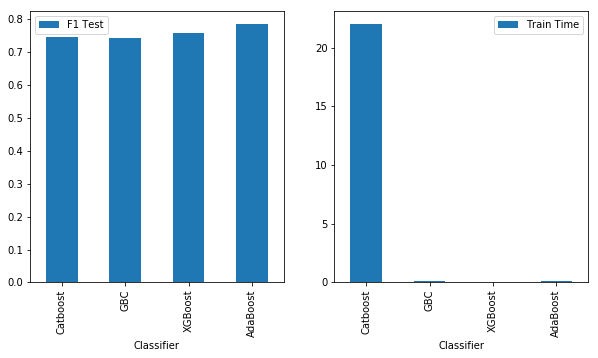

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results.sort_values('F1 Train', ascending=False, inplace=True)
results.plot(y=['F1 Test'], kind='bar', ax=ax[0], xlim=[0,1.1])
results.plot(y='Train Time', kind='bar', ax=ax[1])

In [19]:
cv = []

for name, model in models.items():
    print(name)
    scores = cross_val_score(model, X=X, y=y, cv=10)
    print("Accuracy: {:0.2f} (+/- {:0.2f})".format(scores.mean(), scores.std()))
    cv.append([name, scores.mean(), scores.std() ])

cv = pd.DataFrame(cv, columns=['Model', 'CV_Mean', 'CV_Std_Dev'])
cv.set_index('Model', inplace=True)

XGBoost
Accuracy: 1.00 (+/- 0.00)
Catboost
0:	learn: 0.6476224	total: 578ms	remaining: 9m 37s
1:	learn: 0.6021159	total: 770ms	remaining: 6m 24s
2:	learn: 0.5594685	total: 867ms	remaining: 4m 48s
3:	learn: 0.5238960	total: 901ms	remaining: 3m 44s
4:	learn: 0.4927958	total: 912ms	remaining: 3m 1s
5:	learn: 0.4600229	total: 974ms	remaining: 2m 41s
6:	learn: 0.4318542	total: 993ms	remaining: 2m 20s
7:	learn: 0.4013778	total: 1.01s	remaining: 2m 4s
8:	learn: 0.3800341	total: 1.02s	remaining: 1m 52s
9:	learn: 0.3574272	total: 1.03s	remaining: 1m 42s
10:	learn: 0.3380583	total: 1.04s	remaining: 1m 33s
11:	learn: 0.3207108	total: 1.05s	remaining: 1m 26s
12:	learn: 0.2996562	total: 1.06s	remaining: 1m 20s
13:	learn: 0.2835442	total: 1.1s	remaining: 1m 17s
14:	learn: 0.2654662	total: 1.11s	remaining: 1m 12s
15:	learn: 0.2484504	total: 1.12s	remaining: 1m 8s
16:	learn: 0.2364219	total: 1.13s	remaining: 1m 5s
17:	learn: 0.2216620	total: 1.14s	remaining: 1m 2s
18:	learn: 0.2104467	total: 1.15s	rem

160:	learn: 0.0131233	total: 4.15s	remaining: 21.6s
161:	learn: 0.0130006	total: 4.17s	remaining: 21.6s
162:	learn: 0.0129434	total: 4.19s	remaining: 21.5s
163:	learn: 0.0127882	total: 4.2s	remaining: 21.4s
164:	learn: 0.0126907	total: 4.22s	remaining: 21.4s
165:	learn: 0.0125411	total: 4.23s	remaining: 21.3s
166:	learn: 0.0123485	total: 4.26s	remaining: 21.2s
167:	learn: 0.0122626	total: 4.27s	remaining: 21.1s
168:	learn: 0.0121789	total: 4.28s	remaining: 21s
169:	learn: 0.0120661	total: 4.29s	remaining: 20.9s
170:	learn: 0.0119277	total: 4.29s	remaining: 20.8s
171:	learn: 0.0118137	total: 4.3s	remaining: 20.7s
172:	learn: 0.0117726	total: 4.31s	remaining: 20.6s
173:	learn: 0.0116624	total: 4.32s	remaining: 20.5s
174:	learn: 0.0115876	total: 4.33s	remaining: 20.4s
175:	learn: 0.0115054	total: 4.34s	remaining: 20.3s
176:	learn: 0.0114198	total: 4.35s	remaining: 20.2s
177:	learn: 0.0112833	total: 4.36s	remaining: 20.1s
178:	learn: 0.0111925	total: 4.37s	remaining: 20.1s
179:	learn: 0.01

334:	learn: 0.0043816	total: 7.14s	remaining: 14.2s
335:	learn: 0.0043720	total: 7.16s	remaining: 14.2s
336:	learn: 0.0043433	total: 7.17s	remaining: 14.1s
337:	learn: 0.0043337	total: 7.18s	remaining: 14.1s
338:	learn: 0.0043129	total: 7.19s	remaining: 14s
339:	learn: 0.0042893	total: 7.21s	remaining: 14s
340:	learn: 0.0042698	total: 7.22s	remaining: 13.9s
341:	learn: 0.0042605	total: 7.23s	remaining: 13.9s
342:	learn: 0.0042489	total: 7.24s	remaining: 13.9s
343:	learn: 0.0042292	total: 7.24s	remaining: 13.8s
344:	learn: 0.0042069	total: 7.25s	remaining: 13.8s
345:	learn: 0.0041878	total: 7.26s	remaining: 13.7s
346:	learn: 0.0041629	total: 7.28s	remaining: 13.7s
347:	learn: 0.0041544	total: 7.29s	remaining: 13.7s
348:	learn: 0.0041450	total: 7.3s	remaining: 13.6s
349:	learn: 0.0041254	total: 7.31s	remaining: 13.6s
350:	learn: 0.0041168	total: 7.32s	remaining: 13.5s
351:	learn: 0.0040911	total: 7.33s	remaining: 13.5s
352:	learn: 0.0040825	total: 7.34s	remaining: 13.5s
353:	learn: 0.004

501:	learn: 0.0025607	total: 9.63s	remaining: 9.56s
502:	learn: 0.0025523	total: 9.65s	remaining: 9.54s
503:	learn: 0.0025471	total: 9.66s	remaining: 9.51s
504:	learn: 0.0025352	total: 9.68s	remaining: 9.49s
505:	learn: 0.0025278	total: 9.69s	remaining: 9.46s
506:	learn: 0.0025197	total: 9.7s	remaining: 9.43s
507:	learn: 0.0025158	total: 9.71s	remaining: 9.4s
508:	learn: 0.0025120	total: 9.72s	remaining: 9.38s
509:	learn: 0.0025025	total: 9.73s	remaining: 9.35s
510:	learn: 0.0024979	total: 9.78s	remaining: 9.36s
511:	learn: 0.0024902	total: 9.79s	remaining: 9.34s
512:	learn: 0.0024867	total: 9.81s	remaining: 9.31s
513:	learn: 0.0024785	total: 10s	remaining: 9.47s
514:	learn: 0.0024753	total: 10s	remaining: 9.45s
515:	learn: 0.0024678	total: 10.1s	remaining: 9.44s
516:	learn: 0.0024607	total: 10.1s	remaining: 9.41s
517:	learn: 0.0024565	total: 10.1s	remaining: 9.38s
518:	learn: 0.0024507	total: 10.1s	remaining: 9.36s
519:	learn: 0.0024471	total: 10.1s	remaining: 9.33s
520:	learn: 0.0024

672:	learn: 0.0017710	total: 12.3s	remaining: 5.98s
673:	learn: 0.0017670	total: 12.3s	remaining: 5.96s
674:	learn: 0.0017652	total: 12.3s	remaining: 5.94s
675:	learn: 0.0017634	total: 12.4s	remaining: 5.92s
676:	learn: 0.0017606	total: 12.4s	remaining: 5.9s
677:	learn: 0.0017581	total: 12.4s	remaining: 5.87s
678:	learn: 0.0017564	total: 12.4s	remaining: 5.85s
679:	learn: 0.0017521	total: 12.4s	remaining: 5.83s
680:	learn: 0.0017485	total: 12.4s	remaining: 5.81s
681:	learn: 0.0017457	total: 12.4s	remaining: 5.79s
682:	learn: 0.0017416	total: 12.4s	remaining: 5.76s
683:	learn: 0.0017378	total: 12.4s	remaining: 5.74s
684:	learn: 0.0017336	total: 12.4s	remaining: 5.72s
685:	learn: 0.0017300	total: 12.4s	remaining: 5.7s
686:	learn: 0.0017260	total: 12.5s	remaining: 5.67s
687:	learn: 0.0017243	total: 12.5s	remaining: 5.65s
688:	learn: 0.0017225	total: 12.5s	remaining: 5.63s
689:	learn: 0.0017207	total: 12.5s	remaining: 5.61s
690:	learn: 0.0017189	total: 12.5s	remaining: 5.59s
691:	learn: 0.

833:	learn: 0.0013541	total: 14.2s	remaining: 2.82s
834:	learn: 0.0013519	total: 14.2s	remaining: 2.8s
835:	learn: 0.0013496	total: 14.2s	remaining: 2.78s
836:	learn: 0.0013472	total: 14.2s	remaining: 2.76s
837:	learn: 0.0013456	total: 14.2s	remaining: 2.75s
838:	learn: 0.0013442	total: 14.2s	remaining: 2.73s
839:	learn: 0.0013430	total: 14.2s	remaining: 2.71s
840:	learn: 0.0013408	total: 14.2s	remaining: 2.69s
841:	learn: 0.0013398	total: 14.2s	remaining: 2.67s
842:	learn: 0.0013374	total: 14.3s	remaining: 2.65s
843:	learn: 0.0013361	total: 14.3s	remaining: 2.64s
844:	learn: 0.0013349	total: 14.3s	remaining: 2.62s
845:	learn: 0.0013338	total: 14.3s	remaining: 2.6s
846:	learn: 0.0013327	total: 14.3s	remaining: 2.58s
847:	learn: 0.0013307	total: 14.3s	remaining: 2.56s
848:	learn: 0.0013285	total: 14.3s	remaining: 2.55s
849:	learn: 0.0013274	total: 14.3s	remaining: 2.53s
850:	learn: 0.0013262	total: 14.3s	remaining: 2.51s
851:	learn: 0.0013251	total: 14.4s	remaining: 2.49s
852:	learn: 0.

994:	learn: 0.0010957	total: 16s	remaining: 80.5ms
995:	learn: 0.0010939	total: 16s	remaining: 64.4ms
996:	learn: 0.0010923	total: 16s	remaining: 48.3ms
997:	learn: 0.0010915	total: 16.1s	remaining: 32.2ms
998:	learn: 0.0010906	total: 16.1s	remaining: 16.1ms
999:	learn: 0.0010895	total: 16.1s	remaining: 0us
0:	learn: 0.6487183	total: 12.3ms	remaining: 12.2s
1:	learn: 0.6040802	total: 31.5ms	remaining: 15.7s
2:	learn: 0.5633674	total: 38.6ms	remaining: 12.8s
3:	learn: 0.5223686	total: 49ms	remaining: 12.2s
4:	learn: 0.4919783	total: 60.2ms	remaining: 12s
5:	learn: 0.4596472	total: 71.6ms	remaining: 11.9s
6:	learn: 0.4330270	total: 83.9ms	remaining: 11.9s
7:	learn: 0.4047662	total: 95.9ms	remaining: 11.9s
8:	learn: 0.3827493	total: 107ms	remaining: 11.7s
9:	learn: 0.3595484	total: 117ms	remaining: 11.6s
10:	learn: 0.3375347	total: 128ms	remaining: 11.5s
11:	learn: 0.3193887	total: 139ms	remaining: 11.4s
12:	learn: 0.2974744	total: 149ms	remaining: 11.3s
13:	learn: 0.2842925	total: 159ms	

164:	learn: 0.0102079	total: 1.82s	remaining: 9.22s
165:	learn: 0.0101253	total: 1.83s	remaining: 9.21s
166:	learn: 0.0100096	total: 1.84s	remaining: 9.2s
167:	learn: 0.0099147	total: 1.85s	remaining: 9.19s
168:	learn: 0.0098032	total: 1.87s	remaining: 9.18s
169:	learn: 0.0096475	total: 1.88s	remaining: 9.2s
170:	learn: 0.0095606	total: 1.9s	remaining: 9.2s
171:	learn: 0.0094768	total: 1.91s	remaining: 9.18s
172:	learn: 0.0093804	total: 1.92s	remaining: 9.17s
173:	learn: 0.0092613	total: 1.93s	remaining: 9.16s
174:	learn: 0.0091886	total: 1.94s	remaining: 9.13s
175:	learn: 0.0091168	total: 1.95s	remaining: 9.12s
176:	learn: 0.0090342	total: 1.96s	remaining: 9.1s
177:	learn: 0.0089458	total: 1.97s	remaining: 9.09s
178:	learn: 0.0089013	total: 1.98s	remaining: 9.08s
179:	learn: 0.0088254	total: 1.99s	remaining: 9.07s
180:	learn: 0.0087234	total: 2s	remaining: 9.05s
181:	learn: 0.0086585	total: 2.01s	remaining: 9.04s
182:	learn: 0.0085773	total: 2.02s	remaining: 9.03s
183:	learn: 0.008480

330:	learn: 0.0034298	total: 3.63s	remaining: 7.34s
331:	learn: 0.0034150	total: 3.65s	remaining: 7.34s
332:	learn: 0.0034003	total: 3.67s	remaining: 7.34s
333:	learn: 0.0033833	total: 3.68s	remaining: 7.33s
334:	learn: 0.0033734	total: 3.69s	remaining: 7.32s
335:	learn: 0.0033640	total: 3.7s	remaining: 7.31s
336:	learn: 0.0033492	total: 3.71s	remaining: 7.3s
337:	learn: 0.0033353	total: 3.72s	remaining: 7.28s
338:	learn: 0.0033215	total: 3.73s	remaining: 7.27s
339:	learn: 0.0033074	total: 3.74s	remaining: 7.26s
340:	learn: 0.0032940	total: 3.75s	remaining: 7.25s
341:	learn: 0.0032850	total: 3.76s	remaining: 7.24s
342:	learn: 0.0032684	total: 3.77s	remaining: 7.23s
343:	learn: 0.0032560	total: 3.78s	remaining: 7.22s
344:	learn: 0.0032402	total: 3.79s	remaining: 7.2s
345:	learn: 0.0032270	total: 3.8s	remaining: 7.19s
346:	learn: 0.0032145	total: 3.82s	remaining: 7.18s
347:	learn: 0.0032028	total: 3.83s	remaining: 7.18s
348:	learn: 0.0031906	total: 3.84s	remaining: 7.17s
349:	learn: 0.00

491:	learn: 0.0020923	total: 5.44s	remaining: 5.61s
492:	learn: 0.0020847	total: 5.44s	remaining: 5.6s
493:	learn: 0.0020787	total: 5.45s	remaining: 5.58s
494:	learn: 0.0020728	total: 5.46s	remaining: 5.57s
495:	learn: 0.0020700	total: 5.47s	remaining: 5.56s
496:	learn: 0.0020639	total: 5.49s	remaining: 5.55s
497:	learn: 0.0020598	total: 5.5s	remaining: 5.54s
498:	learn: 0.0020568	total: 5.51s	remaining: 5.53s
499:	learn: 0.0020512	total: 5.52s	remaining: 5.52s
500:	learn: 0.0020463	total: 5.53s	remaining: 5.51s
501:	learn: 0.0020399	total: 5.54s	remaining: 5.5s
502:	learn: 0.0020361	total: 5.55s	remaining: 5.48s
503:	learn: 0.0020306	total: 5.56s	remaining: 5.47s
504:	learn: 0.0020270	total: 5.57s	remaining: 5.46s
505:	learn: 0.0020241	total: 5.58s	remaining: 5.45s
506:	learn: 0.0020180	total: 5.6s	remaining: 5.44s
507:	learn: 0.0020125	total: 5.61s	remaining: 5.43s
508:	learn: 0.0020096	total: 5.62s	remaining: 5.42s
509:	learn: 0.0020042	total: 5.63s	remaining: 5.41s
510:	learn: 0.00

650:	learn: 0.0015167	total: 7.26s	remaining: 3.89s
651:	learn: 0.0015137	total: 7.27s	remaining: 3.88s
652:	learn: 0.0015103	total: 7.29s	remaining: 3.87s
653:	learn: 0.0015077	total: 7.31s	remaining: 3.87s
654:	learn: 0.0015046	total: 7.33s	remaining: 3.86s
655:	learn: 0.0015011	total: 7.34s	remaining: 3.85s
656:	learn: 0.0014981	total: 7.35s	remaining: 3.84s
657:	learn: 0.0014953	total: 7.37s	remaining: 3.83s
658:	learn: 0.0014924	total: 7.38s	remaining: 3.82s
659:	learn: 0.0014894	total: 7.39s	remaining: 3.81s
660:	learn: 0.0014864	total: 7.4s	remaining: 3.79s
661:	learn: 0.0014835	total: 7.41s	remaining: 3.78s
662:	learn: 0.0014810	total: 7.42s	remaining: 3.77s
663:	learn: 0.0014777	total: 7.43s	remaining: 3.76s
664:	learn: 0.0014748	total: 7.44s	remaining: 3.75s
665:	learn: 0.0014719	total: 7.46s	remaining: 3.74s
666:	learn: 0.0014690	total: 7.47s	remaining: 3.73s
667:	learn: 0.0014666	total: 7.49s	remaining: 3.72s
668:	learn: 0.0014645	total: 7.5s	remaining: 3.71s
669:	learn: 0.

813:	learn: 0.0011760	total: 9.11s	remaining: 2.08s
814:	learn: 0.0011746	total: 9.12s	remaining: 2.07s
815:	learn: 0.0011733	total: 9.14s	remaining: 2.06s
816:	learn: 0.0011714	total: 9.15s	remaining: 2.05s
817:	learn: 0.0011701	total: 9.16s	remaining: 2.04s
818:	learn: 0.0011682	total: 9.17s	remaining: 2.03s
819:	learn: 0.0011664	total: 9.19s	remaining: 2.02s
820:	learn: 0.0011651	total: 9.2s	remaining: 2s
821:	learn: 0.0011638	total: 9.21s	remaining: 1.99s
822:	learn: 0.0011624	total: 9.22s	remaining: 1.98s
823:	learn: 0.0011610	total: 9.23s	remaining: 1.97s
824:	learn: 0.0011589	total: 9.24s	remaining: 1.96s
825:	learn: 0.0011572	total: 9.25s	remaining: 1.95s
826:	learn: 0.0011561	total: 9.26s	remaining: 1.94s
827:	learn: 0.0011547	total: 9.27s	remaining: 1.93s
828:	learn: 0.0011537	total: 9.28s	remaining: 1.92s
829:	learn: 0.0011519	total: 9.29s	remaining: 1.9s
830:	learn: 0.0011501	total: 9.31s	remaining: 1.89s
831:	learn: 0.0011482	total: 9.32s	remaining: 1.88s
832:	learn: 0.001

977:	learn: 0.0009640	total: 11s	remaining: 246ms
978:	learn: 0.0009630	total: 11s	remaining: 235ms
979:	learn: 0.0009619	total: 11s	remaining: 224ms
980:	learn: 0.0009610	total: 11s	remaining: 213ms
981:	learn: 0.0009598	total: 11s	remaining: 202ms
982:	learn: 0.0009585	total: 11s	remaining: 191ms
983:	learn: 0.0009570	total: 11s	remaining: 179ms
984:	learn: 0.0009560	total: 11s	remaining: 168ms
985:	learn: 0.0009549	total: 11.1s	remaining: 157ms
986:	learn: 0.0009538	total: 11.1s	remaining: 146ms
987:	learn: 0.0009529	total: 11.1s	remaining: 134ms
988:	learn: 0.0009520	total: 11.1s	remaining: 123ms
989:	learn: 0.0009510	total: 11.1s	remaining: 112ms
990:	learn: 0.0009502	total: 11.1s	remaining: 101ms
991:	learn: 0.0009492	total: 11.1s	remaining: 89.6ms
992:	learn: 0.0009483	total: 11.1s	remaining: 78.4ms
993:	learn: 0.0009472	total: 11.1s	remaining: 67.2ms
994:	learn: 0.0009459	total: 11.1s	remaining: 56ms
995:	learn: 0.0009450	total: 11.2s	remaining: 44.8ms
996:	learn: 0.0009440	tot

153:	learn: 0.0105469	total: 1.67s	remaining: 9.18s
154:	learn: 0.0103981	total: 1.69s	remaining: 9.2s
155:	learn: 0.0103028	total: 1.7s	remaining: 9.2s
156:	learn: 0.0102200	total: 1.71s	remaining: 9.19s
157:	learn: 0.0100894	total: 1.72s	remaining: 9.17s
158:	learn: 0.0100330	total: 1.73s	remaining: 9.16s
159:	learn: 0.0099292	total: 1.74s	remaining: 9.13s
160:	learn: 0.0098744	total: 1.75s	remaining: 9.11s
161:	learn: 0.0097576	total: 1.76s	remaining: 9.1s
162:	learn: 0.0096479	total: 1.77s	remaining: 9.09s
163:	learn: 0.0095720	total: 1.78s	remaining: 9.07s
164:	learn: 0.0094862	total: 1.79s	remaining: 9.05s
165:	learn: 0.0093854	total: 1.8s	remaining: 9.04s
166:	learn: 0.0093201	total: 1.81s	remaining: 9.03s
167:	learn: 0.0092696	total: 1.84s	remaining: 9.14s
168:	learn: 0.0092093	total: 1.86s	remaining: 9.13s
169:	learn: 0.0091841	total: 1.87s	remaining: 9.12s
170:	learn: 0.0090809	total: 1.88s	remaining: 9.13s
171:	learn: 0.0089845	total: 1.9s	remaining: 9.13s
172:	learn: 0.0089

315:	learn: 0.0035911	total: 3.5s	remaining: 7.59s
316:	learn: 0.0035675	total: 3.52s	remaining: 7.58s
317:	learn: 0.0035529	total: 3.56s	remaining: 7.63s
318:	learn: 0.0035437	total: 3.57s	remaining: 7.62s
319:	learn: 0.0035256	total: 3.58s	remaining: 7.61s
320:	learn: 0.0035071	total: 3.59s	remaining: 7.6s
321:	learn: 0.0034888	total: 3.6s	remaining: 7.57s
322:	learn: 0.0034743	total: 3.61s	remaining: 7.56s
323:	learn: 0.0034604	total: 3.62s	remaining: 7.55s
324:	learn: 0.0034490	total: 3.63s	remaining: 7.53s
325:	learn: 0.0034302	total: 3.64s	remaining: 7.52s
326:	learn: 0.0034169	total: 3.64s	remaining: 7.5s
327:	learn: 0.0034060	total: 3.65s	remaining: 7.49s
328:	learn: 0.0033888	total: 3.66s	remaining: 7.47s
329:	learn: 0.0033779	total: 3.67s	remaining: 7.44s
330:	learn: 0.0033667	total: 3.68s	remaining: 7.43s
331:	learn: 0.0033503	total: 3.69s	remaining: 7.42s
332:	learn: 0.0033337	total: 3.7s	remaining: 7.41s
333:	learn: 0.0033231	total: 3.71s	remaining: 7.4s
334:	learn: 0.0033

477:	learn: 0.0021198	total: 6.11s	remaining: 6.67s
478:	learn: 0.0021163	total: 6.13s	remaining: 6.66s
479:	learn: 0.0021118	total: 6.14s	remaining: 6.65s
480:	learn: 0.0021097	total: 6.16s	remaining: 6.64s
481:	learn: 0.0021037	total: 6.17s	remaining: 6.63s
482:	learn: 0.0020978	total: 6.18s	remaining: 6.61s
483:	learn: 0.0020954	total: 6.19s	remaining: 6.6s
484:	learn: 0.0020908	total: 6.21s	remaining: 6.59s
485:	learn: 0.0020847	total: 6.22s	remaining: 6.58s
486:	learn: 0.0020793	total: 6.23s	remaining: 6.56s
487:	learn: 0.0020728	total: 6.24s	remaining: 6.55s
488:	learn: 0.0020690	total: 6.25s	remaining: 6.54s
489:	learn: 0.0020644	total: 6.27s	remaining: 6.53s
490:	learn: 0.0020595	total: 6.28s	remaining: 6.51s
491:	learn: 0.0020525	total: 6.29s	remaining: 6.49s
492:	learn: 0.0020486	total: 6.3s	remaining: 6.48s
493:	learn: 0.0020412	total: 6.32s	remaining: 6.47s
494:	learn: 0.0020377	total: 6.33s	remaining: 6.46s
495:	learn: 0.0020337	total: 6.35s	remaining: 6.45s
496:	learn: 0.

638:	learn: 0.0014839	total: 8.34s	remaining: 4.71s
639:	learn: 0.0014806	total: 8.36s	remaining: 4.7s
640:	learn: 0.0014783	total: 8.37s	remaining: 4.69s
641:	learn: 0.0014757	total: 8.38s	remaining: 4.67s
642:	learn: 0.0014726	total: 8.4s	remaining: 4.66s
643:	learn: 0.0014704	total: 8.41s	remaining: 4.65s
644:	learn: 0.0014691	total: 8.42s	remaining: 4.63s
645:	learn: 0.0014659	total: 8.43s	remaining: 4.62s
646:	learn: 0.0014643	total: 8.44s	remaining: 4.61s
647:	learn: 0.0014621	total: 8.46s	remaining: 4.59s
648:	learn: 0.0014581	total: 8.47s	remaining: 4.58s
649:	learn: 0.0014538	total: 8.48s	remaining: 4.57s
650:	learn: 0.0014509	total: 8.5s	remaining: 4.55s
651:	learn: 0.0014475	total: 8.51s	remaining: 4.54s
652:	learn: 0.0014440	total: 8.52s	remaining: 4.53s
653:	learn: 0.0014422	total: 8.53s	remaining: 4.51s
654:	learn: 0.0014404	total: 8.54s	remaining: 4.5s
655:	learn: 0.0014366	total: 8.55s	remaining: 4.49s
656:	learn: 0.0014331	total: 8.56s	remaining: 4.47s
657:	learn: 0.00

806:	learn: 0.0011336	total: 10.3s	remaining: 2.46s
807:	learn: 0.0011323	total: 10.3s	remaining: 2.45s
808:	learn: 0.0011304	total: 10.3s	remaining: 2.44s
809:	learn: 0.0011280	total: 10.3s	remaining: 2.42s
810:	learn: 0.0011270	total: 10.3s	remaining: 2.41s
811:	learn: 0.0011236	total: 10.3s	remaining: 2.4s
812:	learn: 0.0011217	total: 10.4s	remaining: 2.38s
813:	learn: 0.0011200	total: 10.4s	remaining: 2.37s
814:	learn: 0.0011184	total: 10.4s	remaining: 2.36s
815:	learn: 0.0011168	total: 10.4s	remaining: 2.34s
816:	learn: 0.0011151	total: 10.4s	remaining: 2.33s
817:	learn: 0.0011138	total: 10.4s	remaining: 2.32s
818:	learn: 0.0011119	total: 10.4s	remaining: 2.3s
819:	learn: 0.0011098	total: 10.4s	remaining: 2.29s
820:	learn: 0.0011082	total: 10.4s	remaining: 2.28s
821:	learn: 0.0011066	total: 10.5s	remaining: 2.26s
822:	learn: 0.0011036	total: 10.5s	remaining: 2.25s
823:	learn: 0.0011019	total: 10.5s	remaining: 2.24s
824:	learn: 0.0011004	total: 10.5s	remaining: 2.23s
825:	learn: 0.

967:	learn: 0.0009245	total: 12.1s	remaining: 400ms
968:	learn: 0.0009234	total: 12.1s	remaining: 388ms
969:	learn: 0.0009222	total: 12.1s	remaining: 375ms
970:	learn: 0.0009212	total: 12.1s	remaining: 363ms
971:	learn: 0.0009203	total: 12.2s	remaining: 350ms
972:	learn: 0.0009188	total: 12.2s	remaining: 337ms
973:	learn: 0.0009177	total: 12.2s	remaining: 325ms
974:	learn: 0.0009167	total: 12.2s	remaining: 312ms
975:	learn: 0.0009155	total: 12.2s	remaining: 300ms
976:	learn: 0.0009145	total: 12.2s	remaining: 287ms
977:	learn: 0.0009134	total: 12.2s	remaining: 275ms
978:	learn: 0.0009126	total: 12.2s	remaining: 262ms
979:	learn: 0.0009115	total: 12.2s	remaining: 250ms
980:	learn: 0.0009105	total: 12.2s	remaining: 237ms
981:	learn: 0.0009084	total: 12.3s	remaining: 225ms
982:	learn: 0.0009073	total: 12.3s	remaining: 212ms
983:	learn: 0.0009065	total: 12.3s	remaining: 200ms
984:	learn: 0.0009055	total: 12.3s	remaining: 188ms
985:	learn: 0.0009049	total: 12.3s	remaining: 175ms
986:	learn: 

137:	learn: 0.0132915	total: 1.62s	remaining: 10.1s
138:	learn: 0.0131581	total: 1.63s	remaining: 10.1s
139:	learn: 0.0130210	total: 1.65s	remaining: 10.1s
140:	learn: 0.0128988	total: 1.66s	remaining: 10.1s
141:	learn: 0.0128020	total: 1.67s	remaining: 10.1s
142:	learn: 0.0126175	total: 1.68s	remaining: 10.1s
143:	learn: 0.0125035	total: 1.7s	remaining: 10.1s
144:	learn: 0.0124085	total: 1.71s	remaining: 10.1s
145:	learn: 0.0123250	total: 1.72s	remaining: 10.1s
146:	learn: 0.0122316	total: 1.73s	remaining: 10s
147:	learn: 0.0121383	total: 1.74s	remaining: 9.99s
148:	learn: 0.0120358	total: 1.75s	remaining: 9.99s
149:	learn: 0.0119172	total: 1.76s	remaining: 9.97s
150:	learn: 0.0117025	total: 1.77s	remaining: 9.94s
151:	learn: 0.0115237	total: 1.78s	remaining: 9.93s
152:	learn: 0.0113913	total: 1.79s	remaining: 9.92s
153:	learn: 0.0112762	total: 1.8s	remaining: 9.91s
154:	learn: 0.0111853	total: 1.81s	remaining: 9.89s
155:	learn: 0.0110832	total: 1.83s	remaining: 9.91s
156:	learn: 0.01

300:	learn: 0.0039918	total: 3.47s	remaining: 8.05s
301:	learn: 0.0039786	total: 3.48s	remaining: 8.04s
302:	learn: 0.0039596	total: 3.49s	remaining: 8.04s
303:	learn: 0.0039394	total: 3.5s	remaining: 8.02s
304:	learn: 0.0039190	total: 3.51s	remaining: 8s
305:	learn: 0.0039001	total: 3.52s	remaining: 7.99s
306:	learn: 0.0038835	total: 3.53s	remaining: 7.98s
307:	learn: 0.0038643	total: 3.54s	remaining: 7.96s
308:	learn: 0.0038459	total: 3.55s	remaining: 7.94s
309:	learn: 0.0038316	total: 3.56s	remaining: 7.93s
310:	learn: 0.0038135	total: 3.57s	remaining: 7.91s
311:	learn: 0.0037947	total: 3.58s	remaining: 7.9s
312:	learn: 0.0037769	total: 3.59s	remaining: 7.89s
313:	learn: 0.0037656	total: 3.61s	remaining: 7.88s
314:	learn: 0.0037484	total: 3.62s	remaining: 7.87s
315:	learn: 0.0037378	total: 3.63s	remaining: 7.85s
316:	learn: 0.0037133	total: 3.64s	remaining: 7.84s
317:	learn: 0.0036964	total: 3.64s	remaining: 7.81s
318:	learn: 0.0036804	total: 3.65s	remaining: 7.8s
319:	learn: 0.0036

475:	learn: 0.0021947	total: 5.46s	remaining: 6s
476:	learn: 0.0021900	total: 5.47s	remaining: 6s
477:	learn: 0.0021852	total: 5.49s	remaining: 5.99s
478:	learn: 0.0021770	total: 5.49s	remaining: 5.97s
479:	learn: 0.0021715	total: 5.5s	remaining: 5.96s
480:	learn: 0.0021646	total: 5.51s	remaining: 5.95s
481:	learn: 0.0021606	total: 5.52s	remaining: 5.93s
482:	learn: 0.0021569	total: 5.53s	remaining: 5.92s
483:	learn: 0.0021518	total: 5.55s	remaining: 5.91s
484:	learn: 0.0021459	total: 5.55s	remaining: 5.9s
485:	learn: 0.0021404	total: 5.56s	remaining: 5.88s
486:	learn: 0.0021355	total: 5.57s	remaining: 5.87s
487:	learn: 0.0021308	total: 5.58s	remaining: 5.86s
488:	learn: 0.0021265	total: 5.59s	remaining: 5.85s
489:	learn: 0.0021209	total: 5.61s	remaining: 5.83s
490:	learn: 0.0021155	total: 5.62s	remaining: 5.82s
491:	learn: 0.0021125	total: 5.63s	remaining: 5.81s
492:	learn: 0.0021070	total: 5.64s	remaining: 5.8s
493:	learn: 0.0021028	total: 5.65s	remaining: 5.79s
494:	learn: 0.0020968

640:	learn: 0.0015486	total: 7.29s	remaining: 4.08s
641:	learn: 0.0015465	total: 7.31s	remaining: 4.08s
642:	learn: 0.0015433	total: 7.33s	remaining: 4.07s
643:	learn: 0.0015401	total: 7.33s	remaining: 4.05s
644:	learn: 0.0015384	total: 7.35s	remaining: 4.04s
645:	learn: 0.0015356	total: 7.36s	remaining: 4.03s
646:	learn: 0.0015331	total: 7.37s	remaining: 4.02s
647:	learn: 0.0015316	total: 7.38s	remaining: 4.01s
648:	learn: 0.0015282	total: 7.39s	remaining: 4s
649:	learn: 0.0015258	total: 7.4s	remaining: 3.98s
650:	learn: 0.0015235	total: 7.41s	remaining: 3.97s
651:	learn: 0.0015206	total: 7.42s	remaining: 3.96s
652:	learn: 0.0015161	total: 7.43s	remaining: 3.95s
653:	learn: 0.0015133	total: 7.44s	remaining: 3.94s
654:	learn: 0.0015103	total: 7.45s	remaining: 3.92s
655:	learn: 0.0015073	total: 7.46s	remaining: 3.91s
656:	learn: 0.0015048	total: 7.47s	remaining: 3.9s
657:	learn: 0.0015010	total: 7.49s	remaining: 3.89s
658:	learn: 0.0014985	total: 7.5s	remaining: 3.88s
659:	learn: 0.0014

813:	learn: 0.0011769	total: 9.32s	remaining: 2.13s
814:	learn: 0.0011755	total: 9.33s	remaining: 2.12s
815:	learn: 0.0011738	total: 9.35s	remaining: 2.11s
816:	learn: 0.0011721	total: 9.36s	remaining: 2.1s
817:	learn: 0.0011707	total: 9.37s	remaining: 2.08s
818:	learn: 0.0011690	total: 9.39s	remaining: 2.08s
819:	learn: 0.0011681	total: 9.4s	remaining: 2.06s
820:	learn: 0.0011665	total: 9.42s	remaining: 2.05s
821:	learn: 0.0011655	total: 9.44s	remaining: 2.04s
822:	learn: 0.0011636	total: 9.47s	remaining: 2.04s
823:	learn: 0.0011623	total: 9.49s	remaining: 2.03s
824:	learn: 0.0011605	total: 9.5s	remaining: 2.02s
825:	learn: 0.0011589	total: 9.51s	remaining: 2s
826:	learn: 0.0011571	total: 9.53s	remaining: 1.99s
827:	learn: 0.0011557	total: 9.54s	remaining: 1.98s
828:	learn: 0.0011540	total: 9.55s	remaining: 1.97s
829:	learn: 0.0011524	total: 9.56s	remaining: 1.96s
830:	learn: 0.0011504	total: 9.57s	remaining: 1.95s
831:	learn: 0.0011483	total: 9.58s	remaining: 1.93s
832:	learn: 0.0011

990:	learn: 0.0009442	total: 11.5s	remaining: 105ms
991:	learn: 0.0009427	total: 11.6s	remaining: 93.2ms
992:	learn: 0.0009417	total: 11.6s	remaining: 81.5ms
993:	learn: 0.0009412	total: 11.6s	remaining: 69.9ms
994:	learn: 0.0009403	total: 11.6s	remaining: 58.3ms
995:	learn: 0.0009392	total: 11.6s	remaining: 46.6ms
996:	learn: 0.0009386	total: 11.6s	remaining: 34.9ms
997:	learn: 0.0009376	total: 11.6s	remaining: 23.3ms
998:	learn: 0.0009368	total: 11.6s	remaining: 11.6ms
999:	learn: 0.0009356	total: 11.6s	remaining: 0us
0:	learn: 0.6454409	total: 19.2ms	remaining: 19.1s
1:	learn: 0.6049813	total: 33.3ms	remaining: 16.6s
2:	learn: 0.5662203	total: 44.7ms	remaining: 14.9s
3:	learn: 0.5276977	total: 56.3ms	remaining: 14s
4:	learn: 0.4902076	total: 67.5ms	remaining: 13.4s
5:	learn: 0.4627485	total: 78.6ms	remaining: 13s
6:	learn: 0.4358974	total: 88.9ms	remaining: 12.6s
7:	learn: 0.4040158	total: 96ms	remaining: 11.9s
8:	learn: 0.3794778	total: 106ms	remaining: 11.7s
9:	learn: 0.3570635	to

166:	learn: 0.0091107	total: 1.87s	remaining: 9.34s
167:	learn: 0.0090297	total: 1.9s	remaining: 9.42s
168:	learn: 0.0089900	total: 1.91s	remaining: 9.4s
169:	learn: 0.0089099	total: 1.92s	remaining: 9.39s
170:	learn: 0.0088177	total: 1.93s	remaining: 9.38s
171:	learn: 0.0087321	total: 1.94s	remaining: 9.36s
172:	learn: 0.0086538	total: 1.95s	remaining: 9.34s
173:	learn: 0.0085779	total: 1.96s	remaining: 9.32s
174:	learn: 0.0085082	total: 1.97s	remaining: 9.3s
175:	learn: 0.0084287	total: 1.98s	remaining: 9.29s
176:	learn: 0.0083579	total: 2s	remaining: 9.28s
177:	learn: 0.0082946	total: 2s	remaining: 9.26s
178:	learn: 0.0082377	total: 2.01s	remaining: 9.23s
179:	learn: 0.0081752	total: 2.02s	remaining: 9.19s
180:	learn: 0.0080774	total: 2.02s	remaining: 9.15s
181:	learn: 0.0080110	total: 2.03s	remaining: 9.14s
182:	learn: 0.0079677	total: 2.04s	remaining: 9.11s
183:	learn: 0.0079256	total: 2.05s	remaining: 9.1s
184:	learn: 0.0078251	total: 2.06s	remaining: 9.08s
185:	learn: 0.0077492	

331:	learn: 0.0033346	total: 3.7s	remaining: 7.45s
332:	learn: 0.0033175	total: 3.71s	remaining: 7.43s
333:	learn: 0.0033083	total: 3.72s	remaining: 7.42s
334:	learn: 0.0032952	total: 3.73s	remaining: 7.41s
335:	learn: 0.0032834	total: 3.75s	remaining: 7.4s
336:	learn: 0.0032696	total: 3.75s	remaining: 7.39s
337:	learn: 0.0032617	total: 3.77s	remaining: 7.38s
338:	learn: 0.0032517	total: 3.78s	remaining: 7.37s
339:	learn: 0.0032386	total: 3.79s	remaining: 7.35s
340:	learn: 0.0032326	total: 3.8s	remaining: 7.34s
341:	learn: 0.0032218	total: 3.81s	remaining: 7.33s
342:	learn: 0.0032094	total: 3.82s	remaining: 7.32s
343:	learn: 0.0031910	total: 3.83s	remaining: 7.31s
344:	learn: 0.0031771	total: 3.84s	remaining: 7.29s
345:	learn: 0.0031628	total: 3.85s	remaining: 7.28s
346:	learn: 0.0031548	total: 3.86s	remaining: 7.27s
347:	learn: 0.0031457	total: 3.87s	remaining: 7.26s
348:	learn: 0.0031313	total: 3.89s	remaining: 7.25s
349:	learn: 0.0031247	total: 3.9s	remaining: 7.24s
350:	learn: 0.00

501:	learn: 0.0020515	total: 5.67s	remaining: 5.63s
502:	learn: 0.0020452	total: 5.69s	remaining: 5.62s
503:	learn: 0.0020403	total: 5.7s	remaining: 5.61s
504:	learn: 0.0020341	total: 5.72s	remaining: 5.6s
505:	learn: 0.0020306	total: 5.73s	remaining: 5.59s
506:	learn: 0.0020277	total: 5.74s	remaining: 5.58s
507:	learn: 0.0020219	total: 5.75s	remaining: 5.57s
508:	learn: 0.0020165	total: 5.76s	remaining: 5.55s
509:	learn: 0.0020134	total: 5.77s	remaining: 5.54s
510:	learn: 0.0020106	total: 5.78s	remaining: 5.53s
511:	learn: 0.0020057	total: 5.79s	remaining: 5.52s
512:	learn: 0.0020011	total: 5.8s	remaining: 5.51s
513:	learn: 0.0019960	total: 5.81s	remaining: 5.5s
514:	learn: 0.0019906	total: 5.82s	remaining: 5.48s
515:	learn: 0.0019862	total: 5.83s	remaining: 5.47s
516:	learn: 0.0019834	total: 5.85s	remaining: 5.46s
517:	learn: 0.0019782	total: 5.86s	remaining: 5.45s
518:	learn: 0.0019715	total: 5.88s	remaining: 5.44s
519:	learn: 0.0019672	total: 5.89s	remaining: 5.44s
520:	learn: 0.00

678:	learn: 0.0014681	total: 7.74s	remaining: 3.66s
679:	learn: 0.0014653	total: 7.76s	remaining: 3.65s
680:	learn: 0.0014643	total: 7.77s	remaining: 3.64s
681:	learn: 0.0014618	total: 7.79s	remaining: 3.63s
682:	learn: 0.0014599	total: 7.8s	remaining: 3.62s
683:	learn: 0.0014571	total: 7.81s	remaining: 3.61s
684:	learn: 0.0014545	total: 7.82s	remaining: 3.59s
685:	learn: 0.0014535	total: 7.83s	remaining: 3.58s
686:	learn: 0.0014511	total: 7.84s	remaining: 3.57s
687:	learn: 0.0014484	total: 7.85s	remaining: 3.56s
688:	learn: 0.0014444	total: 7.86s	remaining: 3.55s
689:	learn: 0.0014427	total: 7.87s	remaining: 3.53s
690:	learn: 0.0014404	total: 7.88s	remaining: 3.52s
691:	learn: 0.0014367	total: 7.89s	remaining: 3.51s
692:	learn: 0.0014348	total: 7.91s	remaining: 3.5s
693:	learn: 0.0014335	total: 7.92s	remaining: 3.49s
694:	learn: 0.0014303	total: 7.93s	remaining: 3.48s
695:	learn: 0.0014268	total: 7.96s	remaining: 3.47s
696:	learn: 0.0014233	total: 7.98s	remaining: 3.47s
697:	learn: 0.

840:	learn: 0.0011609	total: 9.6s	remaining: 1.81s
841:	learn: 0.0011603	total: 9.62s	remaining: 1.8s
842:	learn: 0.0011586	total: 9.63s	remaining: 1.79s
843:	learn: 0.0011571	total: 9.64s	remaining: 1.78s
844:	learn: 0.0011554	total: 9.65s	remaining: 1.77s
845:	learn: 0.0011539	total: 9.66s	remaining: 1.76s
846:	learn: 0.0011528	total: 9.67s	remaining: 1.75s
847:	learn: 0.0011518	total: 9.68s	remaining: 1.74s
848:	learn: 0.0011501	total: 9.69s	remaining: 1.72s
849:	learn: 0.0011488	total: 9.7s	remaining: 1.71s
850:	learn: 0.0011469	total: 9.71s	remaining: 1.7s
851:	learn: 0.0011458	total: 9.72s	remaining: 1.69s
852:	learn: 0.0011439	total: 9.73s	remaining: 1.68s
853:	learn: 0.0011422	total: 9.75s	remaining: 1.67s
854:	learn: 0.0011409	total: 9.76s	remaining: 1.65s
855:	learn: 0.0011402	total: 9.77s	remaining: 1.64s
856:	learn: 0.0011386	total: 9.78s	remaining: 1.63s
857:	learn: 0.0011368	total: 9.79s	remaining: 1.62s
858:	learn: 0.0011354	total: 9.8s	remaining: 1.61s
859:	learn: 0.001

0:	learn: 0.6469744	total: 10.9ms	remaining: 10.9s
1:	learn: 0.6093542	total: 21.5ms	remaining: 10.7s
2:	learn: 0.5669829	total: 34.5ms	remaining: 11.5s
3:	learn: 0.5301820	total: 45.5ms	remaining: 11.3s
4:	learn: 0.4976568	total: 55.8ms	remaining: 11.1s
5:	learn: 0.4643486	total: 66.9ms	remaining: 11.1s
6:	learn: 0.4326289	total: 75.6ms	remaining: 10.7s
7:	learn: 0.4055887	total: 86.6ms	remaining: 10.7s
8:	learn: 0.3848525	total: 97.2ms	remaining: 10.7s
9:	learn: 0.3672558	total: 108ms	remaining: 10.7s
10:	learn: 0.3447693	total: 118ms	remaining: 10.6s
11:	learn: 0.3193633	total: 129ms	remaining: 10.6s
12:	learn: 0.3002461	total: 141ms	remaining: 10.7s
13:	learn: 0.2828022	total: 150ms	remaining: 10.6s
14:	learn: 0.2666756	total: 160ms	remaining: 10.5s
15:	learn: 0.2501393	total: 171ms	remaining: 10.5s
16:	learn: 0.2374095	total: 182ms	remaining: 10.5s
17:	learn: 0.2277241	total: 192ms	remaining: 10.5s
18:	learn: 0.2144253	total: 204ms	remaining: 10.5s
19:	learn: 0.2043930	total: 220m

179:	learn: 0.0093801	total: 1.97s	remaining: 8.99s
180:	learn: 0.0093025	total: 2s	remaining: 9.04s
181:	learn: 0.0091955	total: 2s	remaining: 8.99s
182:	learn: 0.0091181	total: 2.02s	remaining: 9.01s
183:	learn: 0.0090346	total: 2.03s	remaining: 8.99s
184:	learn: 0.0089133	total: 2.03s	remaining: 8.95s
185:	learn: 0.0088187	total: 2.04s	remaining: 8.95s
186:	learn: 0.0087592	total: 2.06s	remaining: 8.94s
187:	learn: 0.0086817	total: 2.06s	remaining: 8.91s
188:	learn: 0.0085754	total: 2.07s	remaining: 8.9s
189:	learn: 0.0084794	total: 2.08s	remaining: 8.88s
190:	learn: 0.0084187	total: 2.09s	remaining: 8.87s
191:	learn: 0.0083452	total: 2.1s	remaining: 8.86s
192:	learn: 0.0082935	total: 2.12s	remaining: 8.85s
193:	learn: 0.0082316	total: 2.12s	remaining: 8.81s
194:	learn: 0.0081679	total: 2.13s	remaining: 8.8s
195:	learn: 0.0081046	total: 2.14s	remaining: 8.78s
196:	learn: 0.0080388	total: 2.15s	remaining: 8.77s
197:	learn: 0.0079624	total: 2.16s	remaining: 8.74s
198:	learn: 0.0078891

347:	learn: 0.0033939	total: 3.77s	remaining: 7.06s
348:	learn: 0.0033812	total: 3.79s	remaining: 7.06s
349:	learn: 0.0033633	total: 3.79s	remaining: 7.04s
350:	learn: 0.0033495	total: 3.8s	remaining: 7.03s
351:	learn: 0.0033368	total: 3.81s	remaining: 7.01s
352:	learn: 0.0033253	total: 3.82s	remaining: 7s
353:	learn: 0.0033129	total: 3.83s	remaining: 7s
354:	learn: 0.0033016	total: 3.84s	remaining: 6.98s
355:	learn: 0.0032907	total: 3.85s	remaining: 6.97s
356:	learn: 0.0032804	total: 3.87s	remaining: 6.96s
357:	learn: 0.0032669	total: 3.88s	remaining: 6.95s
358:	learn: 0.0032563	total: 3.88s	remaining: 6.94s
359:	learn: 0.0032410	total: 3.9s	remaining: 6.93s
360:	learn: 0.0032309	total: 3.91s	remaining: 6.92s
361:	learn: 0.0032197	total: 3.92s	remaining: 6.9s
362:	learn: 0.0032050	total: 3.93s	remaining: 6.89s
363:	learn: 0.0031947	total: 3.94s	remaining: 6.88s
364:	learn: 0.0031787	total: 3.94s	remaining: 6.86s
365:	learn: 0.0031685	total: 3.96s	remaining: 6.85s
366:	learn: 0.0031576

512:	learn: 0.0020579	total: 5.61s	remaining: 5.32s
513:	learn: 0.0020535	total: 5.62s	remaining: 5.32s
514:	learn: 0.0020497	total: 5.64s	remaining: 5.31s
515:	learn: 0.0020466	total: 5.65s	remaining: 5.3s
516:	learn: 0.0020414	total: 5.66s	remaining: 5.29s
517:	learn: 0.0020364	total: 5.67s	remaining: 5.28s
518:	learn: 0.0020317	total: 5.69s	remaining: 5.27s
519:	learn: 0.0020256	total: 5.7s	remaining: 5.26s
520:	learn: 0.0020215	total: 5.71s	remaining: 5.25s
521:	learn: 0.0020172	total: 5.72s	remaining: 5.24s
522:	learn: 0.0020133	total: 5.73s	remaining: 5.23s
523:	learn: 0.0020085	total: 5.74s	remaining: 5.21s
524:	learn: 0.0020030	total: 5.75s	remaining: 5.2s
525:	learn: 0.0019998	total: 5.76s	remaining: 5.19s
526:	learn: 0.0019936	total: 5.78s	remaining: 5.18s
527:	learn: 0.0019895	total: 5.79s	remaining: 5.17s
528:	learn: 0.0019842	total: 5.8s	remaining: 5.16s
529:	learn: 0.0019820	total: 5.81s	remaining: 5.16s
530:	learn: 0.0019767	total: 5.83s	remaining: 5.15s
531:	learn: 0.00

674:	learn: 0.0014854	total: 7.54s	remaining: 3.63s
675:	learn: 0.0014819	total: 7.56s	remaining: 3.62s
676:	learn: 0.0014789	total: 7.57s	remaining: 3.61s
677:	learn: 0.0014763	total: 7.6s	remaining: 3.61s
678:	learn: 0.0014736	total: 7.61s	remaining: 3.6s
679:	learn: 0.0014701	total: 7.61s	remaining: 3.58s
680:	learn: 0.0014671	total: 7.63s	remaining: 3.57s
681:	learn: 0.0014646	total: 7.64s	remaining: 3.56s
682:	learn: 0.0014622	total: 7.65s	remaining: 3.55s
683:	learn: 0.0014598	total: 7.66s	remaining: 3.54s
684:	learn: 0.0014570	total: 7.67s	remaining: 3.53s
685:	learn: 0.0014548	total: 7.68s	remaining: 3.52s
686:	learn: 0.0014525	total: 7.69s	remaining: 3.5s
687:	learn: 0.0014499	total: 7.71s	remaining: 3.49s
688:	learn: 0.0014471	total: 7.72s	remaining: 3.48s
689:	learn: 0.0014438	total: 7.73s	remaining: 3.47s
690:	learn: 0.0014406	total: 7.75s	remaining: 3.46s
691:	learn: 0.0014385	total: 7.76s	remaining: 3.46s
692:	learn: 0.0014363	total: 7.79s	remaining: 3.45s
693:	learn: 0.0

834:	learn: 0.0011611	total: 9.46s	remaining: 1.87s
835:	learn: 0.0011595	total: 9.47s	remaining: 1.86s
836:	learn: 0.0011576	total: 9.49s	remaining: 1.85s
837:	learn: 0.0011565	total: 9.5s	remaining: 1.84s
838:	learn: 0.0011550	total: 9.51s	remaining: 1.82s
839:	learn: 0.0011535	total: 9.52s	remaining: 1.81s
840:	learn: 0.0011518	total: 9.53s	remaining: 1.8s
841:	learn: 0.0011500	total: 9.54s	remaining: 1.79s
842:	learn: 0.0011483	total: 9.55s	remaining: 1.78s
843:	learn: 0.0011465	total: 9.56s	remaining: 1.77s
844:	learn: 0.0011451	total: 9.58s	remaining: 1.76s
845:	learn: 0.0011437	total: 9.59s	remaining: 1.75s
846:	learn: 0.0011423	total: 9.6s	remaining: 1.73s
847:	learn: 0.0011406	total: 9.61s	remaining: 1.72s
848:	learn: 0.0011391	total: 9.62s	remaining: 1.71s
849:	learn: 0.0011375	total: 9.63s	remaining: 1.7s
850:	learn: 0.0011360	total: 9.64s	remaining: 1.69s
851:	learn: 0.0011342	total: 9.66s	remaining: 1.68s
852:	learn: 0.0011329	total: 9.67s	remaining: 1.67s
853:	learn: 0.00

0:	learn: 0.6442069	total: 20.7ms	remaining: 20.6s
1:	learn: 0.5908048	total: 34.2ms	remaining: 17.1s
2:	learn: 0.5509741	total: 55.5ms	remaining: 18.4s
3:	learn: 0.5154252	total: 66.5ms	remaining: 16.6s
4:	learn: 0.4764192	total: 77.8ms	remaining: 15.5s
5:	learn: 0.4400598	total: 91.1ms	remaining: 15.1s
6:	learn: 0.4034330	total: 102ms	remaining: 14.4s
7:	learn: 0.3845507	total: 112ms	remaining: 13.9s
8:	learn: 0.3565837	total: 123ms	remaining: 13.6s
9:	learn: 0.3339660	total: 134ms	remaining: 13.2s
10:	learn: 0.3181902	total: 144ms	remaining: 13s
11:	learn: 0.2997882	total: 155ms	remaining: 12.8s
12:	learn: 0.2780845	total: 166ms	remaining: 12.6s
13:	learn: 0.2591851	total: 176ms	remaining: 12.4s
14:	learn: 0.2419360	total: 187ms	remaining: 12.3s
15:	learn: 0.2262605	total: 197ms	remaining: 12.1s
16:	learn: 0.2129889	total: 208ms	remaining: 12s
17:	learn: 0.1997493	total: 218ms	remaining: 11.9s
18:	learn: 0.1922069	total: 236ms	remaining: 12.2s
19:	learn: 0.1838661	total: 249ms	remai

170:	learn: 0.0067628	total: 2.8s	remaining: 13.6s
171:	learn: 0.0067021	total: 2.82s	remaining: 13.6s
172:	learn: 0.0066491	total: 2.83s	remaining: 13.5s
173:	learn: 0.0065880	total: 2.84s	remaining: 13.5s
174:	learn: 0.0065104	total: 2.85s	remaining: 13.5s
175:	learn: 0.0064529	total: 2.87s	remaining: 13.4s
176:	learn: 0.0063928	total: 2.88s	remaining: 13.4s
177:	learn: 0.0062907	total: 2.88s	remaining: 13.3s
178:	learn: 0.0062164	total: 2.89s	remaining: 13.2s
179:	learn: 0.0061590	total: 2.9s	remaining: 13.2s
180:	learn: 0.0060894	total: 2.91s	remaining: 13.2s
181:	learn: 0.0060479	total: 2.92s	remaining: 13.1s
182:	learn: 0.0060092	total: 2.96s	remaining: 13.2s
183:	learn: 0.0059813	total: 2.97s	remaining: 13.2s
184:	learn: 0.0058796	total: 2.98s	remaining: 13.1s
185:	learn: 0.0057902	total: 2.99s	remaining: 13.1s
186:	learn: 0.0057667	total: 3.01s	remaining: 13.1s
187:	learn: 0.0057509	total: 3.02s	remaining: 13s
188:	learn: 0.0056716	total: 3.03s	remaining: 13s
189:	learn: 0.0056

338:	learn: 0.0022108	total: 4.91s	remaining: 9.57s
339:	learn: 0.0022036	total: 5.05s	remaining: 9.8s
340:	learn: 0.0021988	total: 5.06s	remaining: 9.78s
341:	learn: 0.0021923	total: 5.13s	remaining: 9.87s
342:	learn: 0.0021840	total: 5.14s	remaining: 9.85s
343:	learn: 0.0021658	total: 5.14s	remaining: 9.81s
344:	learn: 0.0021581	total: 5.17s	remaining: 9.81s
345:	learn: 0.0021520	total: 5.18s	remaining: 9.79s
346:	learn: 0.0021472	total: 5.2s	remaining: 9.78s
347:	learn: 0.0021425	total: 5.21s	remaining: 9.77s
348:	learn: 0.0021355	total: 5.23s	remaining: 9.75s
349:	learn: 0.0021277	total: 5.24s	remaining: 9.73s
350:	learn: 0.0021219	total: 5.26s	remaining: 9.72s
351:	learn: 0.0021170	total: 5.27s	remaining: 9.7s
352:	learn: 0.0021114	total: 5.28s	remaining: 9.68s
353:	learn: 0.0021043	total: 5.29s	remaining: 9.66s
354:	learn: 0.0020977	total: 5.3s	remaining: 9.64s
355:	learn: 0.0020915	total: 5.32s	remaining: 9.62s
356:	learn: 0.0020878	total: 5.34s	remaining: 9.62s
357:	learn: 0.00

500:	learn: 0.0014050	total: 7.59s	remaining: 7.56s
501:	learn: 0.0014033	total: 7.6s	remaining: 7.54s
502:	learn: 0.0013971	total: 7.61s	remaining: 7.51s
503:	learn: 0.0013923	total: 7.62s	remaining: 7.5s
504:	learn: 0.0013903	total: 7.63s	remaining: 7.48s
505:	learn: 0.0013865	total: 7.64s	remaining: 7.46s
506:	learn: 0.0013845	total: 7.65s	remaining: 7.44s
507:	learn: 0.0013826	total: 7.66s	remaining: 7.42s
508:	learn: 0.0013800	total: 7.67s	remaining: 7.4s
509:	learn: 0.0013758	total: 7.69s	remaining: 7.39s
510:	learn: 0.0013681	total: 7.69s	remaining: 7.36s
511:	learn: 0.0013666	total: 7.7s	remaining: 7.34s
512:	learn: 0.0013626	total: 7.75s	remaining: 7.35s
513:	learn: 0.0013607	total: 7.76s	remaining: 7.34s
514:	learn: 0.0013574	total: 7.77s	remaining: 7.32s
515:	learn: 0.0013537	total: 7.79s	remaining: 7.3s
516:	learn: 0.0013522	total: 7.8s	remaining: 7.28s
517:	learn: 0.0013468	total: 7.81s	remaining: 7.26s
518:	learn: 0.0013440	total: 7.82s	remaining: 7.25s
519:	learn: 0.0013

660:	learn: 0.0010193	total: 10.2s	remaining: 5.23s
661:	learn: 0.0010160	total: 10.2s	remaining: 5.22s
662:	learn: 0.0010146	total: 10.2s	remaining: 5.21s
663:	learn: 0.0010103	total: 10.2s	remaining: 5.19s
664:	learn: 0.0010087	total: 10.3s	remaining: 5.17s
665:	learn: 0.0010069	total: 10.3s	remaining: 5.15s
666:	learn: 0.0010055	total: 10.3s	remaining: 5.14s
667:	learn: 0.0010039	total: 10.3s	remaining: 5.12s
668:	learn: 0.0010019	total: 10.3s	remaining: 5.11s
669:	learn: 0.0010011	total: 10.3s	remaining: 5.09s
670:	learn: 0.0010000	total: 10.4s	remaining: 5.08s
671:	learn: 0.0009986	total: 10.4s	remaining: 5.06s
672:	learn: 0.0009971	total: 10.4s	remaining: 5.05s
673:	learn: 0.0009962	total: 10.4s	remaining: 5.03s
674:	learn: 0.0009951	total: 10.4s	remaining: 5.02s
675:	learn: 0.0009941	total: 10.4s	remaining: 5.01s
676:	learn: 0.0009921	total: 10.5s	remaining: 5s
677:	learn: 0.0009913	total: 10.5s	remaining: 4.98s
678:	learn: 0.0009883	total: 10.5s	remaining: 4.96s
679:	learn: 0.0

830:	learn: 0.0007943	total: 13.2s	remaining: 2.68s
831:	learn: 0.0007933	total: 13.2s	remaining: 2.67s
832:	learn: 0.0007927	total: 13.2s	remaining: 2.65s
833:	learn: 0.0007919	total: 13.2s	remaining: 2.63s
834:	learn: 0.0007910	total: 13.3s	remaining: 2.62s
835:	learn: 0.0007901	total: 13.3s	remaining: 2.6s
836:	learn: 0.0007891	total: 13.3s	remaining: 2.59s
837:	learn: 0.0007884	total: 13.3s	remaining: 2.57s
838:	learn: 0.0007876	total: 13.3s	remaining: 2.56s
839:	learn: 0.0007865	total: 13.4s	remaining: 2.54s
840:	learn: 0.0007855	total: 13.4s	remaining: 2.53s
841:	learn: 0.0007847	total: 13.4s	remaining: 2.51s
842:	learn: 0.0007837	total: 13.4s	remaining: 2.5s
843:	learn: 0.0007824	total: 13.4s	remaining: 2.48s
844:	learn: 0.0007819	total: 13.4s	remaining: 2.46s
845:	learn: 0.0007809	total: 13.5s	remaining: 2.45s
846:	learn: 0.0007803	total: 13.5s	remaining: 2.43s
847:	learn: 0.0007796	total: 13.5s	remaining: 2.42s
848:	learn: 0.0007789	total: 13.5s	remaining: 2.4s
849:	learn: 0.0

993:	learn: 0.0006562	total: 16.3s	remaining: 98.2ms
994:	learn: 0.0006554	total: 16.3s	remaining: 81.8ms
995:	learn: 0.0006550	total: 16.3s	remaining: 65.5ms
996:	learn: 0.0006538	total: 16.3s	remaining: 49.1ms
997:	learn: 0.0006533	total: 16.3s	remaining: 32.7ms
998:	learn: 0.0006525	total: 16.3s	remaining: 16.4ms
999:	learn: 0.0006521	total: 16.4s	remaining: 0us
0:	learn: 0.6411104	total: 12.4ms	remaining: 12.4s
1:	learn: 0.6014655	total: 24.4ms	remaining: 12.2s
2:	learn: 0.5639899	total: 32ms	remaining: 10.6s
3:	learn: 0.5224291	total: 43.2ms	remaining: 10.8s
4:	learn: 0.4846494	total: 54.4ms	remaining: 10.8s
5:	learn: 0.4594104	total: 106ms	remaining: 17.6s
6:	learn: 0.4301672	total: 118ms	remaining: 16.7s
7:	learn: 0.4031806	total: 128ms	remaining: 15.9s
8:	learn: 0.3753262	total: 143ms	remaining: 15.8s
9:	learn: 0.3562428	total: 160ms	remaining: 15.9s
10:	learn: 0.3355001	total: 174ms	remaining: 15.6s
11:	learn: 0.3103450	total: 185ms	remaining: 15.3s
12:	learn: 0.2914700	total:

167:	learn: 0.0094487	total: 2.72s	remaining: 13.5s
168:	learn: 0.0093608	total: 2.74s	remaining: 13.5s
169:	learn: 0.0092840	total: 2.76s	remaining: 13.5s
170:	learn: 0.0092108	total: 2.77s	remaining: 13.4s
171:	learn: 0.0091260	total: 2.78s	remaining: 13.4s
172:	learn: 0.0090633	total: 2.8s	remaining: 13.4s
173:	learn: 0.0090142	total: 2.81s	remaining: 13.3s
174:	learn: 0.0089550	total: 2.83s	remaining: 13.3s
175:	learn: 0.0088916	total: 2.84s	remaining: 13.3s
176:	learn: 0.0088299	total: 2.86s	remaining: 13.3s
177:	learn: 0.0087541	total: 2.87s	remaining: 13.3s
178:	learn: 0.0086850	total: 2.88s	remaining: 13.2s
179:	learn: 0.0086234	total: 2.89s	remaining: 13.2s
180:	learn: 0.0085323	total: 2.9s	remaining: 13.1s
181:	learn: 0.0084514	total: 2.92s	remaining: 13.1s
182:	learn: 0.0083771	total: 2.93s	remaining: 13.1s
183:	learn: 0.0083178	total: 2.97s	remaining: 13.2s
184:	learn: 0.0082448	total: 2.99s	remaining: 13.2s
185:	learn: 0.0081780	total: 3.02s	remaining: 13.2s
186:	learn: 0.

326:	learn: 0.0035004	total: 5.17s	remaining: 10.6s
327:	learn: 0.0034927	total: 5.19s	remaining: 10.6s
328:	learn: 0.0034771	total: 5.22s	remaining: 10.6s
329:	learn: 0.0034651	total: 5.24s	remaining: 10.6s
330:	learn: 0.0034524	total: 5.29s	remaining: 10.7s
331:	learn: 0.0034406	total: 5.35s	remaining: 10.8s
332:	learn: 0.0034290	total: 5.37s	remaining: 10.7s
333:	learn: 0.0034153	total: 5.38s	remaining: 10.7s
334:	learn: 0.0034012	total: 5.39s	remaining: 10.7s
335:	learn: 0.0033879	total: 5.4s	remaining: 10.7s
336:	learn: 0.0033770	total: 5.43s	remaining: 10.7s
337:	learn: 0.0033562	total: 5.43s	remaining: 10.6s
338:	learn: 0.0033438	total: 5.47s	remaining: 10.7s
339:	learn: 0.0033321	total: 5.48s	remaining: 10.6s
340:	learn: 0.0033230	total: 5.5s	remaining: 10.6s
341:	learn: 0.0033055	total: 5.51s	remaining: 10.6s
342:	learn: 0.0032930	total: 5.53s	remaining: 10.6s
343:	learn: 0.0032833	total: 5.54s	remaining: 10.6s
344:	learn: 0.0032737	total: 5.56s	remaining: 10.6s
345:	learn: 0.

491:	learn: 0.0021419	total: 8.08s	remaining: 8.34s
492:	learn: 0.0021383	total: 8.1s	remaining: 8.33s
493:	learn: 0.0021357	total: 8.11s	remaining: 8.31s
494:	learn: 0.0021291	total: 8.13s	remaining: 8.29s
495:	learn: 0.0021235	total: 8.14s	remaining: 8.27s
496:	learn: 0.0021177	total: 8.15s	remaining: 8.25s
497:	learn: 0.0021126	total: 8.16s	remaining: 8.23s
498:	learn: 0.0021076	total: 8.18s	remaining: 8.21s
499:	learn: 0.0021021	total: 8.19s	remaining: 8.19s
500:	learn: 0.0020976	total: 8.21s	remaining: 8.17s
501:	learn: 0.0020933	total: 8.22s	remaining: 8.15s
502:	learn: 0.0020889	total: 8.23s	remaining: 8.13s
503:	learn: 0.0020860	total: 8.24s	remaining: 8.11s
504:	learn: 0.0020812	total: 8.29s	remaining: 8.12s
505:	learn: 0.0020776	total: 8.3s	remaining: 8.1s
506:	learn: 0.0020724	total: 8.31s	remaining: 8.09s
507:	learn: 0.0020687	total: 8.33s	remaining: 8.07s
508:	learn: 0.0020642	total: 8.34s	remaining: 8.05s
509:	learn: 0.0020593	total: 8.36s	remaining: 8.03s
510:	learn: 0.0

662:	learn: 0.0015289	total: 10.8s	remaining: 5.51s
663:	learn: 0.0015267	total: 10.9s	remaining: 5.5s
664:	learn: 0.0015242	total: 10.9s	remaining: 5.49s
665:	learn: 0.0015211	total: 10.9s	remaining: 5.47s
666:	learn: 0.0015189	total: 10.9s	remaining: 5.45s
667:	learn: 0.0015167	total: 10.9s	remaining: 5.43s
668:	learn: 0.0015120	total: 10.9s	remaining: 5.41s
669:	learn: 0.0015088	total: 11s	remaining: 5.4s
670:	learn: 0.0015060	total: 11s	remaining: 5.38s
671:	learn: 0.0015032	total: 11s	remaining: 5.36s
672:	learn: 0.0014981	total: 11s	remaining: 5.34s
673:	learn: 0.0014935	total: 11s	remaining: 5.33s
674:	learn: 0.0014914	total: 11s	remaining: 5.31s
675:	learn: 0.0014889	total: 11s	remaining: 5.29s
676:	learn: 0.0014868	total: 11.1s	remaining: 5.28s
677:	learn: 0.0014843	total: 11.1s	remaining: 5.26s
678:	learn: 0.0014809	total: 11.1s	remaining: 5.25s
679:	learn: 0.0014786	total: 11.1s	remaining: 5.23s
680:	learn: 0.0014753	total: 11.1s	remaining: 5.21s
681:	learn: 0.0014739	total:

825:	learn: 0.0011886	total: 13.5s	remaining: 2.85s
826:	learn: 0.0011871	total: 13.6s	remaining: 2.84s
827:	learn: 0.0011857	total: 13.6s	remaining: 2.82s
828:	learn: 0.0011846	total: 13.6s	remaining: 2.81s
829:	learn: 0.0011832	total: 13.6s	remaining: 2.79s
830:	learn: 0.0011818	total: 13.6s	remaining: 2.77s
831:	learn: 0.0011805	total: 13.7s	remaining: 2.76s
832:	learn: 0.0011782	total: 13.7s	remaining: 2.74s
833:	learn: 0.0011767	total: 13.7s	remaining: 2.72s
834:	learn: 0.0011746	total: 13.7s	remaining: 2.71s
835:	learn: 0.0011736	total: 13.7s	remaining: 2.69s
836:	learn: 0.0011723	total: 13.7s	remaining: 2.67s
837:	learn: 0.0011710	total: 13.7s	remaining: 2.65s
838:	learn: 0.0011693	total: 13.8s	remaining: 2.64s
839:	learn: 0.0011678	total: 13.8s	remaining: 2.63s
840:	learn: 0.0011664	total: 13.8s	remaining: 2.61s
841:	learn: 0.0011650	total: 13.8s	remaining: 2.59s
842:	learn: 0.0011638	total: 13.8s	remaining: 2.58s
843:	learn: 0.0011623	total: 13.8s	remaining: 2.56s
844:	learn: 

993:	learn: 0.0009756	total: 16.3s	remaining: 98.5ms
994:	learn: 0.0009746	total: 16.3s	remaining: 82ms
995:	learn: 0.0009736	total: 16.3s	remaining: 65.6ms
996:	learn: 0.0009728	total: 16.4s	remaining: 49.2ms
997:	learn: 0.0009718	total: 16.4s	remaining: 32.8ms
998:	learn: 0.0009709	total: 16.4s	remaining: 16.4ms
999:	learn: 0.0009696	total: 16.4s	remaining: 0us
0:	learn: 0.6478876	total: 16.7ms	remaining: 16.7s
1:	learn: 0.6090796	total: 29.5ms	remaining: 14.7s
2:	learn: 0.5673052	total: 46.9ms	remaining: 15.6s
3:	learn: 0.5337487	total: 54.1ms	remaining: 13.5s
4:	learn: 0.4949496	total: 72.8ms	remaining: 14.5s
5:	learn: 0.4616278	total: 84.8ms	remaining: 14s
6:	learn: 0.4336389	total: 103ms	remaining: 14.6s
7:	learn: 0.4066470	total: 118ms	remaining: 14.6s
8:	learn: 0.3760113	total: 133ms	remaining: 14.7s
9:	learn: 0.3463669	total: 163ms	remaining: 16.1s
10:	learn: 0.3263947	total: 174ms	remaining: 15.7s
11:	learn: 0.3077457	total: 191ms	remaining: 15.7s
12:	learn: 0.2880115	total: 

162:	learn: 0.0140589	total: 2.63s	remaining: 13.5s
163:	learn: 0.0139563	total: 2.64s	remaining: 13.5s
164:	learn: 0.0139009	total: 2.68s	remaining: 13.6s
165:	learn: 0.0137216	total: 2.69s	remaining: 13.5s
166:	learn: 0.0136876	total: 2.71s	remaining: 13.5s
167:	learn: 0.0135073	total: 2.72s	remaining: 13.5s
168:	learn: 0.0134355	total: 2.73s	remaining: 13.4s
169:	learn: 0.0132469	total: 2.75s	remaining: 13.4s
170:	learn: 0.0130941	total: 2.76s	remaining: 13.4s
171:	learn: 0.0128858	total: 2.77s	remaining: 13.4s
172:	learn: 0.0127117	total: 2.78s	remaining: 13.3s
173:	learn: 0.0125267	total: 2.79s	remaining: 13.3s
174:	learn: 0.0124187	total: 2.8s	remaining: 13.2s
175:	learn: 0.0123171	total: 2.82s	remaining: 13.2s
176:	learn: 0.0122696	total: 2.84s	remaining: 13.2s
177:	learn: 0.0122312	total: 2.86s	remaining: 13.2s
178:	learn: 0.0120683	total: 2.88s	remaining: 13.2s
179:	learn: 0.0120322	total: 2.89s	remaining: 13.2s
180:	learn: 0.0118325	total: 2.91s	remaining: 13.2s
181:	learn: 0

333:	learn: 0.0048044	total: 5.24s	remaining: 10.4s
334:	learn: 0.0047978	total: 5.27s	remaining: 10.5s
335:	learn: 0.0047894	total: 5.28s	remaining: 10.4s
336:	learn: 0.0047751	total: 5.3s	remaining: 10.4s
337:	learn: 0.0047463	total: 5.31s	remaining: 10.4s
338:	learn: 0.0047201	total: 5.32s	remaining: 10.4s
339:	learn: 0.0047008	total: 5.34s	remaining: 10.4s
340:	learn: 0.0046734	total: 5.36s	remaining: 10.3s
341:	learn: 0.0046403	total: 5.37s	remaining: 10.3s
342:	learn: 0.0046264	total: 5.38s	remaining: 10.3s
343:	learn: 0.0046194	total: 5.4s	remaining: 10.3s
344:	learn: 0.0045905	total: 5.42s	remaining: 10.3s
345:	learn: 0.0045844	total: 5.43s	remaining: 10.3s
346:	learn: 0.0045607	total: 5.46s	remaining: 10.3s
347:	learn: 0.0045516	total: 5.47s	remaining: 10.2s
348:	learn: 0.0045206	total: 5.48s	remaining: 10.2s
349:	learn: 0.0044965	total: 5.5s	remaining: 10.2s
350:	learn: 0.0044897	total: 5.51s	remaining: 10.2s
351:	learn: 0.0044746	total: 5.53s	remaining: 10.2s
352:	learn: 0.0

493:	learn: 0.0029547	total: 7.73s	remaining: 7.92s
494:	learn: 0.0029431	total: 7.75s	remaining: 7.91s
495:	learn: 0.0029309	total: 7.78s	remaining: 7.91s
496:	learn: 0.0029233	total: 7.79s	remaining: 7.89s
497:	learn: 0.0029214	total: 7.81s	remaining: 7.88s
498:	learn: 0.0029191	total: 7.83s	remaining: 7.86s
499:	learn: 0.0029170	total: 7.84s	remaining: 7.84s
500:	learn: 0.0029147	total: 7.86s	remaining: 7.83s
501:	learn: 0.0029122	total: 7.87s	remaining: 7.8s
502:	learn: 0.0028986	total: 7.88s	remaining: 7.78s
503:	learn: 0.0028882	total: 7.89s	remaining: 7.77s
504:	learn: 0.0028858	total: 7.9s	remaining: 7.75s
505:	learn: 0.0028807	total: 7.91s	remaining: 7.72s
506:	learn: 0.0028751	total: 7.93s	remaining: 7.71s
507:	learn: 0.0028693	total: 7.96s	remaining: 7.71s
508:	learn: 0.0028631	total: 7.98s	remaining: 7.69s
509:	learn: 0.0028532	total: 7.99s	remaining: 7.68s
510:	learn: 0.0028433	total: 8.01s	remaining: 7.66s
511:	learn: 0.0028321	total: 8.02s	remaining: 7.64s
512:	learn: 0.

655:	learn: 0.0020680	total: 10.2s	remaining: 5.37s
656:	learn: 0.0020663	total: 10.2s	remaining: 5.35s
657:	learn: 0.0020599	total: 10.3s	remaining: 5.33s
658:	learn: 0.0020537	total: 10.3s	remaining: 5.32s
659:	learn: 0.0020525	total: 10.3s	remaining: 5.3s
660:	learn: 0.0020499	total: 10.3s	remaining: 5.29s
661:	learn: 0.0020468	total: 10.3s	remaining: 5.27s
662:	learn: 0.0020444	total: 10.3s	remaining: 5.25s
663:	learn: 0.0020387	total: 10.3s	remaining: 5.23s
664:	learn: 0.0020326	total: 10.4s	remaining: 5.22s
665:	learn: 0.0020275	total: 10.4s	remaining: 5.2s
666:	learn: 0.0020256	total: 10.4s	remaining: 5.18s
667:	learn: 0.0020243	total: 10.4s	remaining: 5.17s
668:	learn: 0.0020213	total: 10.4s	remaining: 5.15s
669:	learn: 0.0020180	total: 10.4s	remaining: 5.13s
670:	learn: 0.0020169	total: 10.5s	remaining: 5.13s
671:	learn: 0.0020146	total: 10.5s	remaining: 5.12s
672:	learn: 0.0020091	total: 10.5s	remaining: 5.1s
673:	learn: 0.0020069	total: 10.5s	remaining: 5.08s
674:	learn: 0.0

821:	learn: 0.0015662	total: 12.8s	remaining: 2.77s
822:	learn: 0.0015630	total: 12.8s	remaining: 2.76s
823:	learn: 0.0015611	total: 12.9s	remaining: 2.75s
824:	learn: 0.0015593	total: 12.9s	remaining: 2.73s
825:	learn: 0.0015583	total: 12.9s	remaining: 2.71s
826:	learn: 0.0015548	total: 12.9s	remaining: 2.7s
827:	learn: 0.0015520	total: 12.9s	remaining: 2.68s
828:	learn: 0.0015490	total: 12.9s	remaining: 2.67s
829:	learn: 0.0015474	total: 12.9s	remaining: 2.65s
830:	learn: 0.0015435	total: 12.9s	remaining: 2.63s
831:	learn: 0.0015401	total: 13s	remaining: 2.62s
832:	learn: 0.0015382	total: 13s	remaining: 2.6s
833:	learn: 0.0015375	total: 13s	remaining: 2.58s
834:	learn: 0.0015345	total: 13s	remaining: 2.57s
835:	learn: 0.0015316	total: 13s	remaining: 2.55s
836:	learn: 0.0015282	total: 13.1s	remaining: 2.54s
837:	learn: 0.0015267	total: 13.1s	remaining: 2.53s
838:	learn: 0.0015259	total: 13.1s	remaining: 2.51s
839:	learn: 0.0015233	total: 13.1s	remaining: 2.49s
840:	learn: 0.0015222	to

984:	learn: 0.0012612	total: 15.4s	remaining: 234ms
985:	learn: 0.0012603	total: 15.4s	remaining: 219ms
986:	learn: 0.0012600	total: 15.4s	remaining: 203ms
987:	learn: 0.0012577	total: 15.5s	remaining: 188ms
988:	learn: 0.0012549	total: 15.5s	remaining: 172ms
989:	learn: 0.0012543	total: 15.5s	remaining: 156ms
990:	learn: 0.0012532	total: 15.5s	remaining: 141ms
991:	learn: 0.0012527	total: 15.5s	remaining: 125ms
992:	learn: 0.0012514	total: 15.5s	remaining: 109ms
993:	learn: 0.0012491	total: 15.5s	remaining: 93.8ms
994:	learn: 0.0012469	total: 15.6s	remaining: 78.1ms
995:	learn: 0.0012465	total: 15.6s	remaining: 62.5ms
996:	learn: 0.0012460	total: 15.6s	remaining: 46.9ms
997:	learn: 0.0012438	total: 15.6s	remaining: 31.3ms
998:	learn: 0.0012432	total: 15.6s	remaining: 15.7ms
999:	learn: 0.0012423	total: 15.7s	remaining: 0us
0:	learn: 0.6457203	total: 12.7ms	remaining: 12.7s
1:	learn: 0.5997910	total: 20.9ms	remaining: 10.4s
2:	learn: 0.5599586	total: 38.3ms	remaining: 12.7s
3:	learn: 0

150:	learn: 0.0089618	total: 2.4s	remaining: 13.5s
151:	learn: 0.0089082	total: 2.42s	remaining: 13.5s
152:	learn: 0.0088319	total: 2.44s	remaining: 13.5s
153:	learn: 0.0086931	total: 2.45s	remaining: 13.5s
154:	learn: 0.0086286	total: 2.47s	remaining: 13.4s
155:	learn: 0.0085195	total: 2.48s	remaining: 13.4s
156:	learn: 0.0084350	total: 2.49s	remaining: 13.4s
157:	learn: 0.0083812	total: 2.5s	remaining: 13.4s
158:	learn: 0.0082855	total: 2.52s	remaining: 13.3s
159:	learn: 0.0081944	total: 2.54s	remaining: 13.3s
160:	learn: 0.0081027	total: 2.54s	remaining: 13.2s
161:	learn: 0.0080266	total: 2.56s	remaining: 13.3s
162:	learn: 0.0079274	total: 2.58s	remaining: 13.2s
163:	learn: 0.0078753	total: 2.59s	remaining: 13.2s
164:	learn: 0.0077947	total: 2.61s	remaining: 13.2s
165:	learn: 0.0077225	total: 2.64s	remaining: 13.2s
166:	learn: 0.0076422	total: 2.65s	remaining: 13.2s
167:	learn: 0.0075568	total: 2.66s	remaining: 13.2s
168:	learn: 0.0074711	total: 2.68s	remaining: 13.2s
169:	learn: 0.

320:	learn: 0.0025993	total: 5.04s	remaining: 10.7s
321:	learn: 0.0025890	total: 5.05s	remaining: 10.6s
322:	learn: 0.0025798	total: 5.07s	remaining: 10.6s
323:	learn: 0.0025688	total: 5.08s	remaining: 10.6s
324:	learn: 0.0025618	total: 5.09s	remaining: 10.6s
325:	learn: 0.0025523	total: 5.11s	remaining: 10.6s
326:	learn: 0.0025432	total: 5.12s	remaining: 10.5s
327:	learn: 0.0025357	total: 5.14s	remaining: 10.5s
328:	learn: 0.0025264	total: 5.16s	remaining: 10.5s
329:	learn: 0.0025173	total: 5.17s	remaining: 10.5s
330:	learn: 0.0025062	total: 5.18s	remaining: 10.5s
331:	learn: 0.0025011	total: 5.2s	remaining: 10.5s
332:	learn: 0.0024917	total: 5.21s	remaining: 10.4s
333:	learn: 0.0024685	total: 5.22s	remaining: 10.4s
334:	learn: 0.0024597	total: 5.25s	remaining: 10.4s
335:	learn: 0.0024503	total: 5.27s	remaining: 10.4s
336:	learn: 0.0024418	total: 5.29s	remaining: 10.4s
337:	learn: 0.0024323	total: 5.3s	remaining: 10.4s
338:	learn: 0.0024271	total: 5.32s	remaining: 10.4s
339:	learn: 0.

479:	learn: 0.0015694	total: 7.55s	remaining: 8.18s
480:	learn: 0.0015669	total: 7.57s	remaining: 8.17s
481:	learn: 0.0015632	total: 7.59s	remaining: 8.16s
482:	learn: 0.0015603	total: 7.61s	remaining: 8.15s
483:	learn: 0.0015574	total: 7.63s	remaining: 8.13s
484:	learn: 0.0015562	total: 7.66s	remaining: 8.13s
485:	learn: 0.0015524	total: 7.67s	remaining: 8.12s
486:	learn: 0.0015492	total: 7.69s	remaining: 8.11s
487:	learn: 0.0015460	total: 7.71s	remaining: 8.09s
488:	learn: 0.0015425	total: 7.72s	remaining: 8.07s
489:	learn: 0.0015395	total: 7.74s	remaining: 8.05s
490:	learn: 0.0015372	total: 7.75s	remaining: 8.04s
491:	learn: 0.0015347	total: 7.78s	remaining: 8.03s
492:	learn: 0.0015314	total: 7.8s	remaining: 8.02s
493:	learn: 0.0015270	total: 7.83s	remaining: 8.02s
494:	learn: 0.0015230	total: 7.84s	remaining: 8s
495:	learn: 0.0015192	total: 7.86s	remaining: 7.98s
496:	learn: 0.0015139	total: 7.87s	remaining: 7.96s
497:	learn: 0.0015101	total: 7.88s	remaining: 7.95s
498:	learn: 0.00

641:	learn: 0.0011435	total: 10.2s	remaining: 5.7s
642:	learn: 0.0011417	total: 10.2s	remaining: 5.68s
643:	learn: 0.0011396	total: 10.2s	remaining: 5.66s
644:	learn: 0.0011384	total: 10.3s	remaining: 5.65s
645:	learn: 0.0011355	total: 10.3s	remaining: 5.63s
646:	learn: 0.0011337	total: 10.3s	remaining: 5.62s
647:	learn: 0.0011324	total: 10.3s	remaining: 5.6s
648:	learn: 0.0011308	total: 10.3s	remaining: 5.58s
649:	learn: 0.0011293	total: 10.3s	remaining: 5.56s
650:	learn: 0.0011275	total: 10.3s	remaining: 5.55s
651:	learn: 0.0011256	total: 10.4s	remaining: 5.54s
652:	learn: 0.0011237	total: 10.4s	remaining: 5.52s
653:	learn: 0.0011222	total: 10.4s	remaining: 5.5s
654:	learn: 0.0011210	total: 10.4s	remaining: 5.49s
655:	learn: 0.0011197	total: 10.4s	remaining: 5.47s
656:	learn: 0.0011178	total: 10.4s	remaining: 5.45s
657:	learn: 0.0011155	total: 10.5s	remaining: 5.43s
658:	learn: 0.0011144	total: 10.5s	remaining: 5.42s
659:	learn: 0.0011121	total: 10.5s	remaining: 5.4s
660:	learn: 0.00

804:	learn: 0.0008935	total: 12.9s	remaining: 3.12s
805:	learn: 0.0008922	total: 12.9s	remaining: 3.11s
806:	learn: 0.0008889	total: 12.9s	remaining: 3.09s
807:	learn: 0.0008878	total: 12.9s	remaining: 3.07s
808:	learn: 0.0008868	total: 12.9s	remaining: 3.06s
809:	learn: 0.0008859	total: 13s	remaining: 3.04s
810:	learn: 0.0008850	total: 13s	remaining: 3.02s
811:	learn: 0.0008841	total: 13s	remaining: 3s
812:	learn: 0.0008834	total: 13s	remaining: 2.99s
813:	learn: 0.0008821	total: 13s	remaining: 2.98s
814:	learn: 0.0008809	total: 13.1s	remaining: 2.96s
815:	learn: 0.0008798	total: 13.1s	remaining: 2.95s
816:	learn: 0.0008788	total: 13.1s	remaining: 2.93s
817:	learn: 0.0008776	total: 13.1s	remaining: 2.91s
818:	learn: 0.0008768	total: 13.1s	remaining: 2.9s
819:	learn: 0.0008761	total: 13.1s	remaining: 2.88s
820:	learn: 0.0008751	total: 13.1s	remaining: 2.87s
821:	learn: 0.0008739	total: 13.2s	remaining: 2.85s
822:	learn: 0.0008730	total: 13.2s	remaining: 2.84s
823:	learn: 0.0008717	tota

964:	learn: 0.0007329	total: 15.4s	remaining: 559ms
965:	learn: 0.0007321	total: 15.4s	remaining: 543ms
966:	learn: 0.0007315	total: 15.4s	remaining: 527ms
967:	learn: 0.0007304	total: 15.4s	remaining: 511ms
968:	learn: 0.0007296	total: 15.5s	remaining: 495ms
969:	learn: 0.0007287	total: 15.5s	remaining: 479ms
970:	learn: 0.0007277	total: 15.5s	remaining: 463ms
971:	learn: 0.0007269	total: 15.5s	remaining: 447ms
972:	learn: 0.0007262	total: 15.5s	remaining: 431ms
973:	learn: 0.0007256	total: 15.5s	remaining: 415ms
974:	learn: 0.0007248	total: 15.5s	remaining: 399ms
975:	learn: 0.0007243	total: 15.6s	remaining: 383ms
976:	learn: 0.0007236	total: 15.6s	remaining: 367ms
977:	learn: 0.0007227	total: 15.6s	remaining: 351ms
978:	learn: 0.0007220	total: 15.6s	remaining: 335ms
979:	learn: 0.0007209	total: 15.6s	remaining: 319ms
980:	learn: 0.0007204	total: 15.6s	remaining: 303ms
981:	learn: 0.0007197	total: 15.7s	remaining: 287ms
982:	learn: 0.0007192	total: 15.7s	remaining: 271ms
983:	learn: 

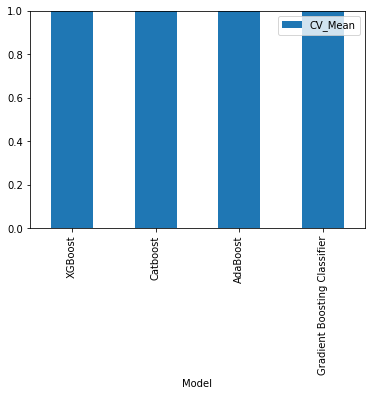

In [20]:
cv.plot(y='CV_Mean', yerr='CV_Std_Dev',kind='bar', ylim=[0, 1])